# Border performance

In [1]:
import os, shutil, sys, warnings, datetime
import numpy as np
import numpy.random as rand
from matplotlib import pyplot as plt, patches as patches
from keras import backend as K, preprocessing as kpre, \
                             datasets as kdat, models as kmod, \
                             layers as klay, optimizers as kopt, \
                             utils as kutil, callbacks as kcall, \
                             initializers as kinit, activations as kact, \
                             regularizers as kreg, applications as kapp
import tensorflow as tf
import cv2 as cv
import cvxpy as cvx
import scipy.fftpack as fft
from lbfgs import fmin_lbfgs
from sklearn import linear_model as slm
from skimage import measure as skm
from tqdm import tnrange, tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from jupyterthemes import jtplot

Using TensorFlow backend.
D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\envs\comps

In [2]:
jtplot.reset()
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

## Initialization cells

In [3]:
def dct2(x):
    return fft.dct(fft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return fft.idct(fft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

class AdaBound(kopt.Optimizer):
    def __init__(self,
                 lr=0.001,
                 final_lr=0.1,
                 beta_1=0.9,
                 beta_2=0.999,
                 gamma=1e-3,
                 epsilon=None,
                 decay=0.,
                 amsbound=False,
                 weight_decay=0.,
                 **kwargs):
        """
        Keras port [1] of AdaBound Optimizer for PyTorch [2], from the paper 
        Adaptive Gradient Methods with Dynamic Bound of Learning Rate [3].
        
        AdaBound optimizer.
        
        Default parameters follow those provided in the original paper.
        # Arguments
            lr: float >= 0. Learning rate.
            final_lr: float >= 0. Final learning rate.
            beta_1: float, 0 < beta < 1. Generally close to 1.
            beta_2: float, 0 < beta < 1. Generally close to 1.
            gamma: float >= 0. Convergence speed of the bound function.
            epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
            decay: float >= 0. Learning rate decay over each update.
            weight_decay: Weight decay weight.
            amsbound: boolean. Whether to apply the AMSBound variant of this
                algorithm.
        
        [1] Majumdar, S. keras-adabound, 2019. https://github.com/titu1994/keras-adabound.
        [2] Luo, L. AdaBound, 2019. https://github.com/Luolc/AdaBound.
        [3] Luo, L., Yuanhao, X., Yan, L., and Xu, S. Adaptive gradient methods with dynamic
            bound of learning rate. International Conference on LEarning Representations, 2019.
            https://openreview.net/forum?id=Bkg3g2R9FX.
        """
        super(AdaBound, self).__init__(**kwargs)
        
        if not 0. < gamma <= 1.:
            raise ValueError('Invalid `gamma` parameter. Must lie in [0, 1] range.')
            
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            
        self.final_lr = final_lr
        self.gamma = gamma
        
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(lr)
        
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates
    
    
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class StopOnValue(kcall.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(kcall.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        
    
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping requires %s available!' % self.monitor, RuntimeWarning)
            
        if current < self.value:
            if self.verbose > 0:
                print('Epoch %05d: early stopping THR' % epoch)
            self.model.stop_training = True
    
def l2loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.nn.l2_loss(y_pred - y_true)

def l1loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.losses.absolute_difference(y_true, y_pred)

def tvloss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

def psnr(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def tv(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

def evaluate(x, g):
    x2 = x.reshape((nx, ny)).T
    Ax2 = idct2(x2)
    Ax = Ax2.T.flat[ri].reshape(b.shape)
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape)
    np.copyto(g, AtAxb)
    return fx

## Train data import & preprocessing

In [13]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/dr2imagenet/TEST/'
img_w = 49
img_h = 49
img_ch = 1

In [14]:
files = os.listdir(traindir)
for f in range(len(files)):
    img = cv.imread(traindir + files[f], 0)
    img = cv.resize(img, (img_w, img_h))
    img = cv.equalizeHist(img)
    if f == 0:
        x_train = np.zeros((len(files), img_h, img_w))
    x_train[f] = img

In [15]:
cap = 10
x_train0 = np.expand_dims(x_train[:cap], -1)
x_train0 = np.tile(x_train0.T, 128//cap).T

## Model setup

In [16]:
sessiondir = '{}/'.format(datetime.datetime.now().strftime('%Y%m%d'))
os.makedirs(sessiondir, exist_ok=True)
batch_size = len(x_train0)
epochs = int(1e6)

In [12]:
amrnn = kmod.Sequential(name='AMRNN')
amrnn.add(klay.Reshape(input_shape=(img_h, img_w, img_ch),
                       target_shape=(img_h, img_w),
                       name='reshape1'))
amrnn.add(klay.CuDNNGRU(units=img_h*img_w,
#                         activation='tanh',
#                         recurrent_activation='hard_sigmoid',
                        name='rnn-gru1'))
amrnn.add(klay.Dense(units=img_h*img_w,
                     activation='sigmoid',
                     name='fc1'))
amrnn.add(klay.Reshape(target_shape=(img_h, img_w, img_ch),
                       name='reshape2'))

amrnn.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape1 (Reshape)           (None, 49, 49)            0         
_________________________________________________________________
rnn-gru1 (CuDNNGRU)          (None, 2401)              17661756  
_________________________________________________________________
fc1 (Dense)                  (None, 2401)              5767202   
_________________________________________________________________
reshape2 (Reshape)           (None, 49, 49, 1)         0         
Total params: 23,428,958
Trainable params: 23,428,958
Non-trainable params: 0
_________________________________________________________________


In [8]:
# history = kcall.History()
checkpoint = kcall.ModelCheckpoint('AMRNN_best_weights.h5',
                                   save_best_only=True,
                                   monitor='loss',
                                   mode='min')
# lr_reduce = kcall.ReduceLROnPlateau(monitor='loss',
#                                     factor=0.1,
#                                     patience=2,
#                                     min_lr=1e-3,
#                                     verbose=0)
csvlogger = kcall.CSVLogger('AMRNN_training.log', 
                            separator=',', 
                            append=False)
os.makedirs('./.tb_logs/', exist_ok=True)
tblogdir = './.tb_logs/%s/' %(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tblog = kcall.TensorBoard(log_dir=tblogdir,
                          histogram_freq=0,
                          write_graph=True,
                          embeddings_freq=0,
                          update_freq='epoch',
                          write_images=False)
# estop = EarlyStopping(monitor='loss',
#                       min_delta=1e-5,
#                       patience=10,
#                       restore_best_weights=True)
stopval = StopOnValue(monitor='loss',
                      value=0.1)

In [16]:
amrnn.compile(loss=l2loss,
              optimizer=AdaBound(lr=1e-3,
                                 final_lr=5e-4),
              metrics=[psnr, ssim])

In [17]:
history = amrnn.fit(x_train0/255,
                    x_train0/255,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[ktqdm(), checkpoint, csvlogger, tblog, stopval])

KeyboardInterrupt: 

In [18]:
amrnn.save('AMRNN.model')

In [9]:
amrnn = kmod.load_model('AMRNN.model', custom_objects={'l2loss': l2loss,
                                                       'psnr': psnr,
                                                       'ssim': ssim,
                                                       'AdaBound': AdaBound})

In [10]:
amrnn.load_weights('AMRNN_best_weights.h5')

## Prepare test data & show results

loss = 25669.5390625 
 psnr = 8.470892906188965 
 ssim = 0.0434361957013607


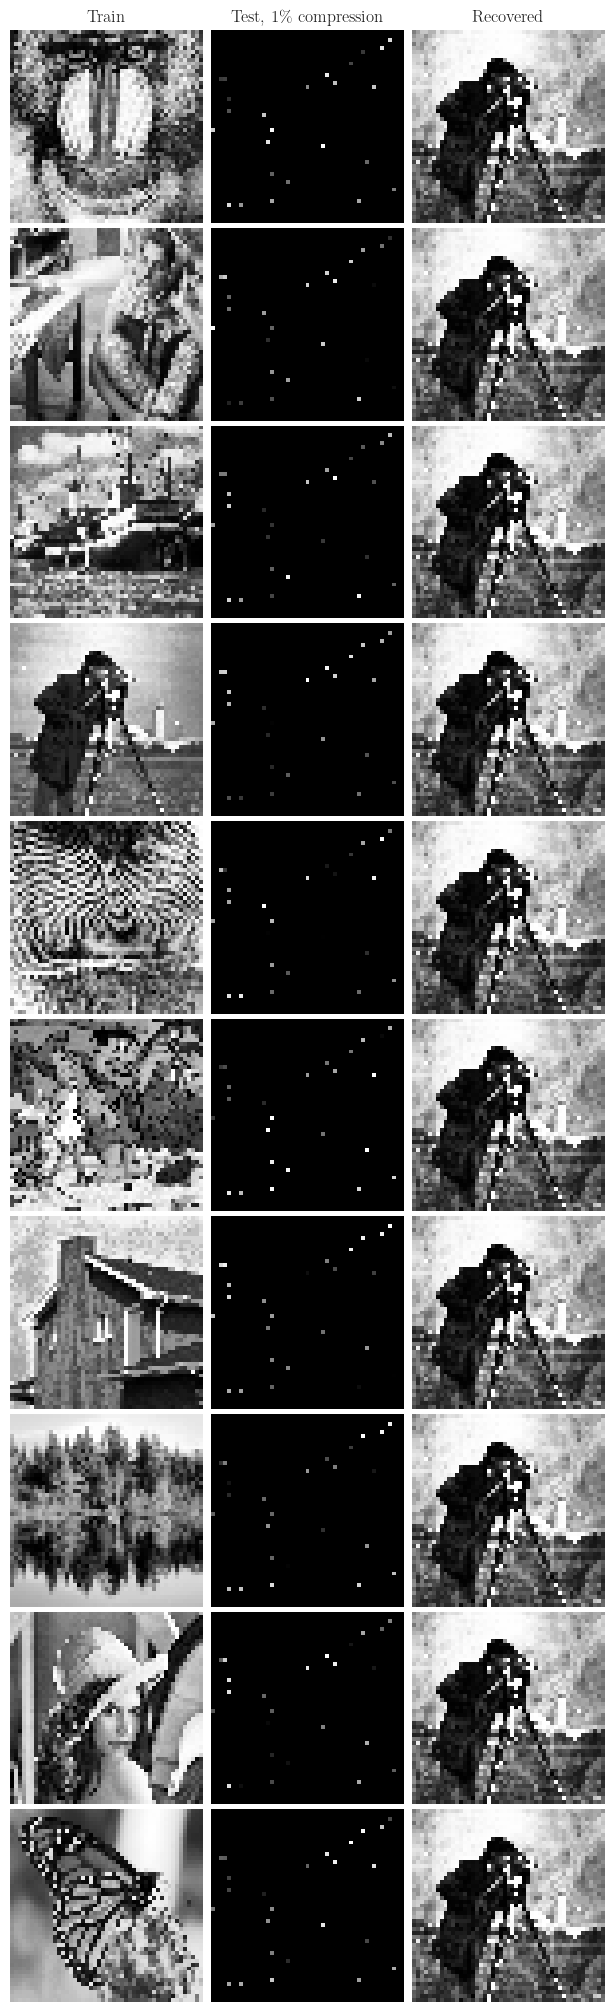

loss = 25985.2890625 
 psnr = 8.337220191955566 
 ssim = 0.0442223958671093


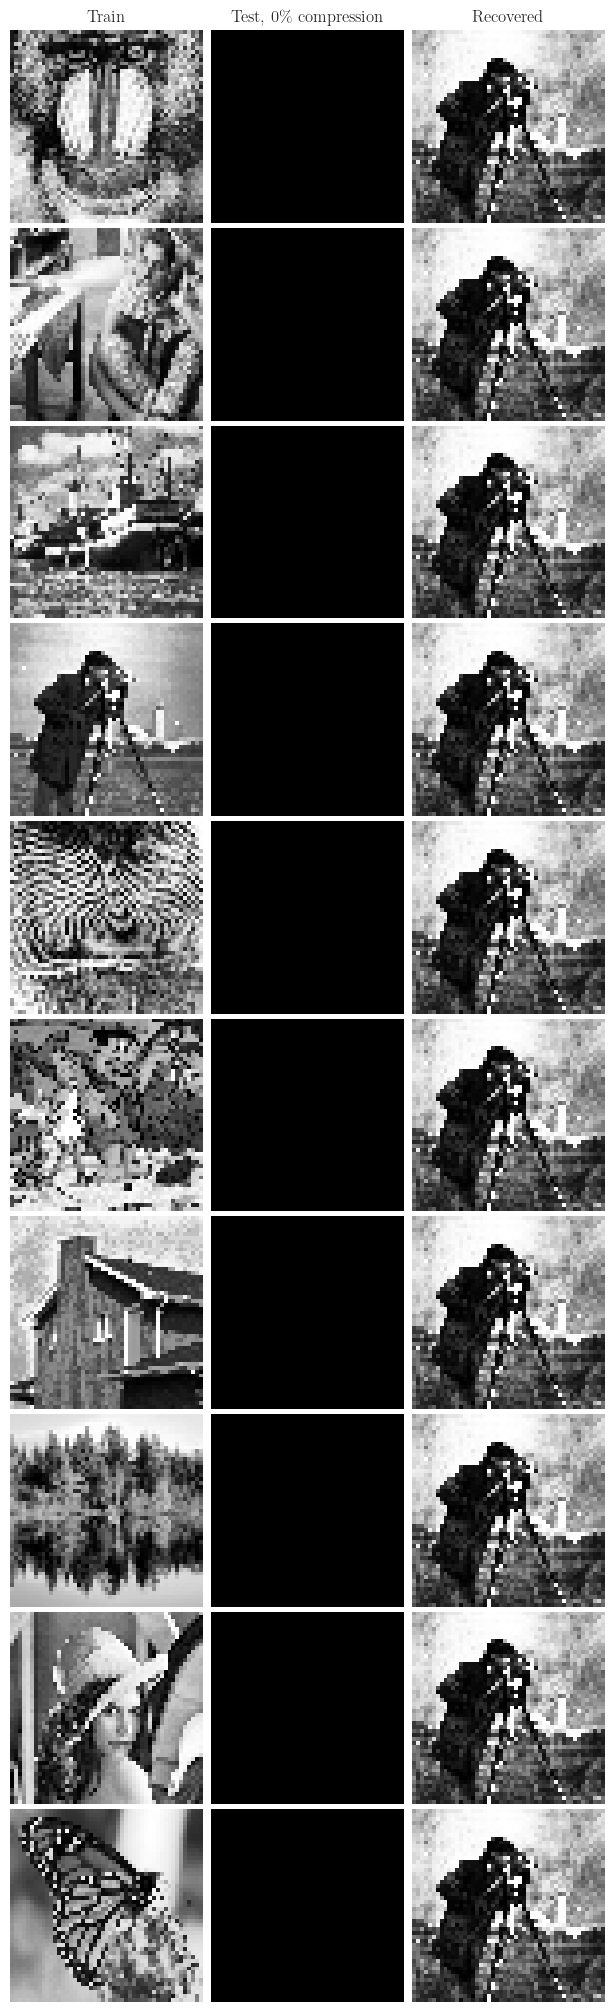

loss = 23528.291015625 
 psnr = 8.876799583435059 
 ssim = 0.08446364849805832


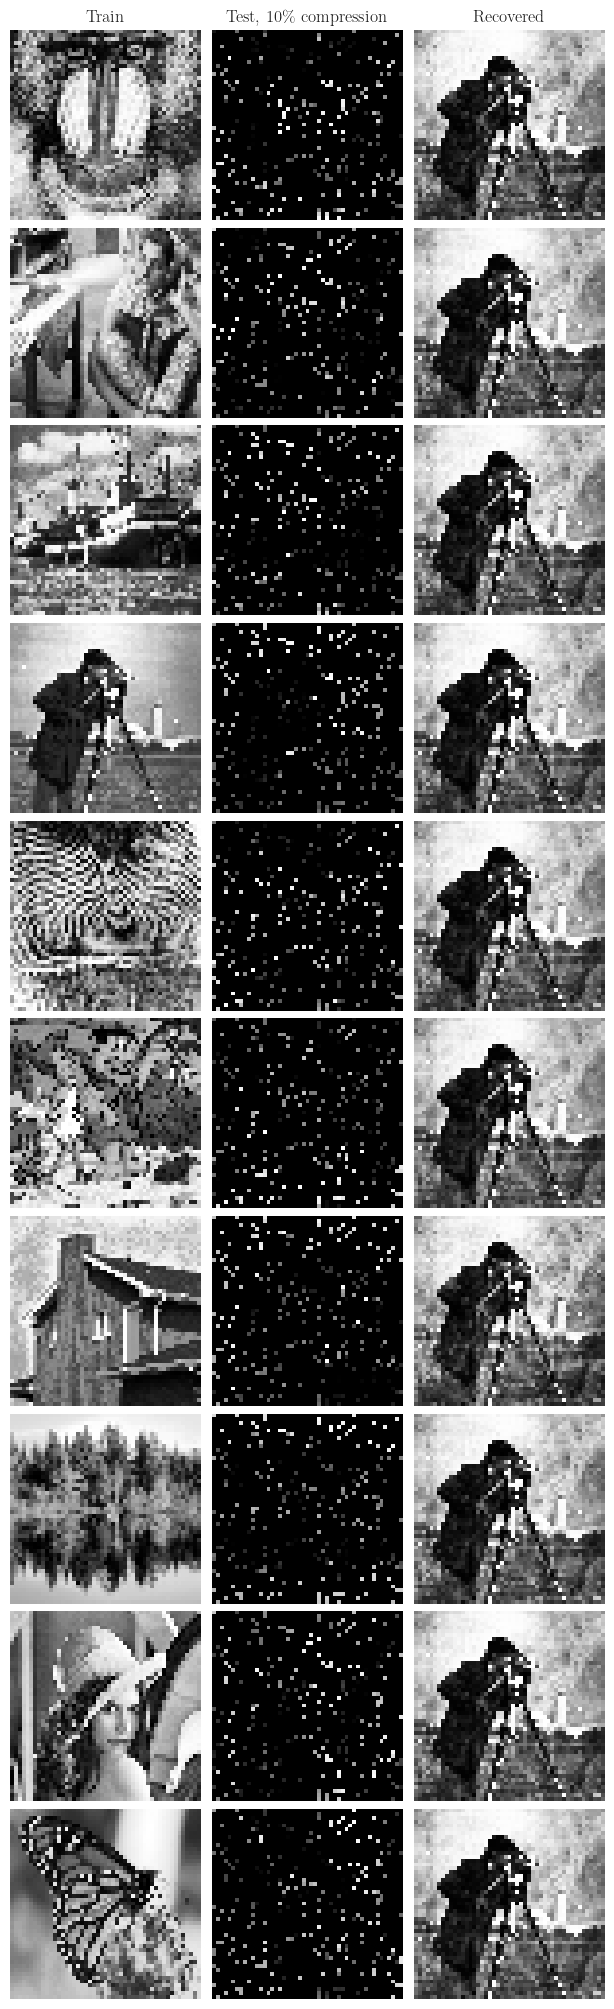

loss = 20978.21484375 
 psnr = 9.359606742858887 
 ssim = 0.11228816956281662


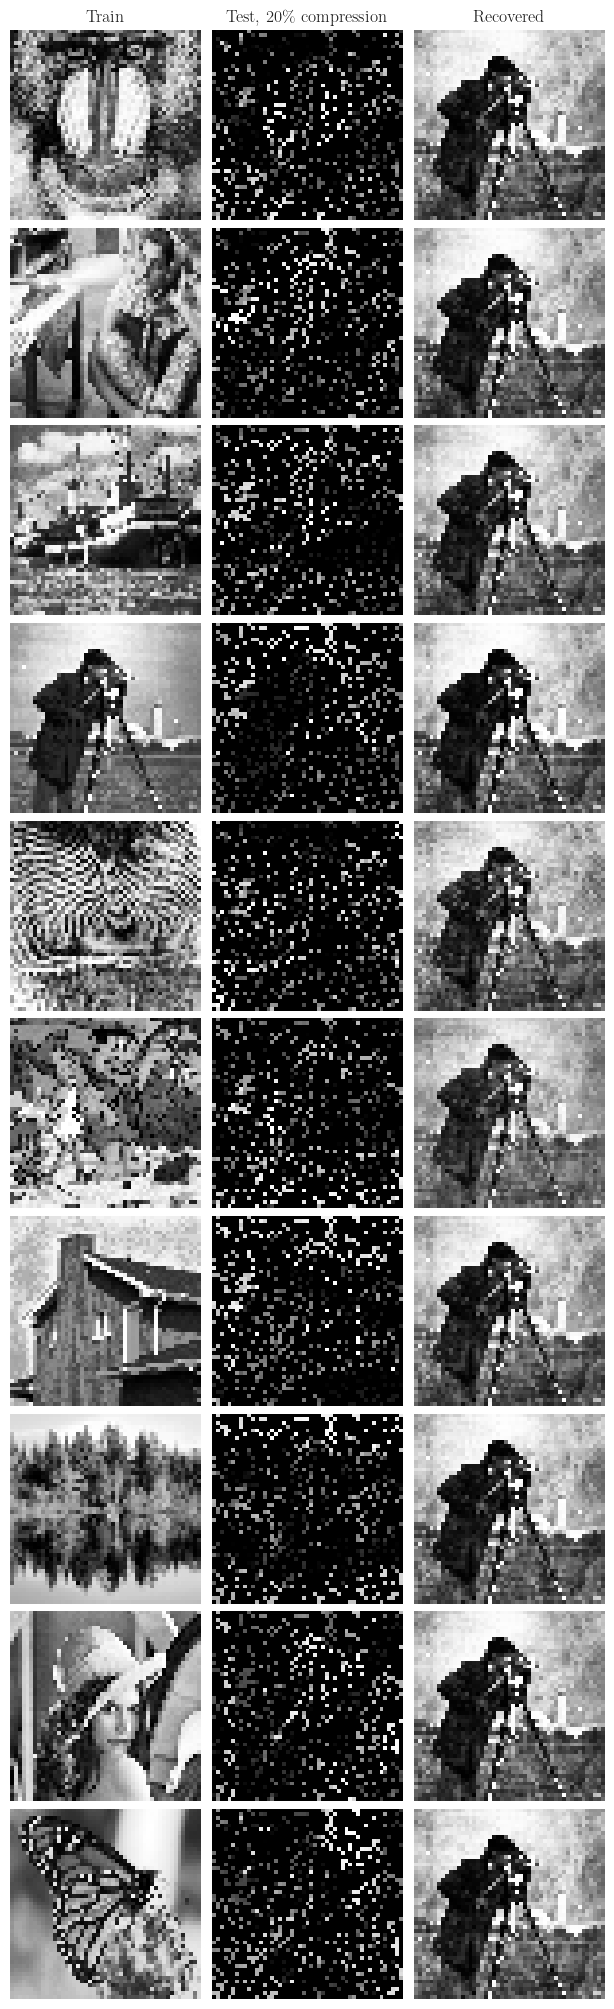

loss = 13953.4287109375 
 psnr = 12.04018497467041 
 ssim = 0.34027329087257385


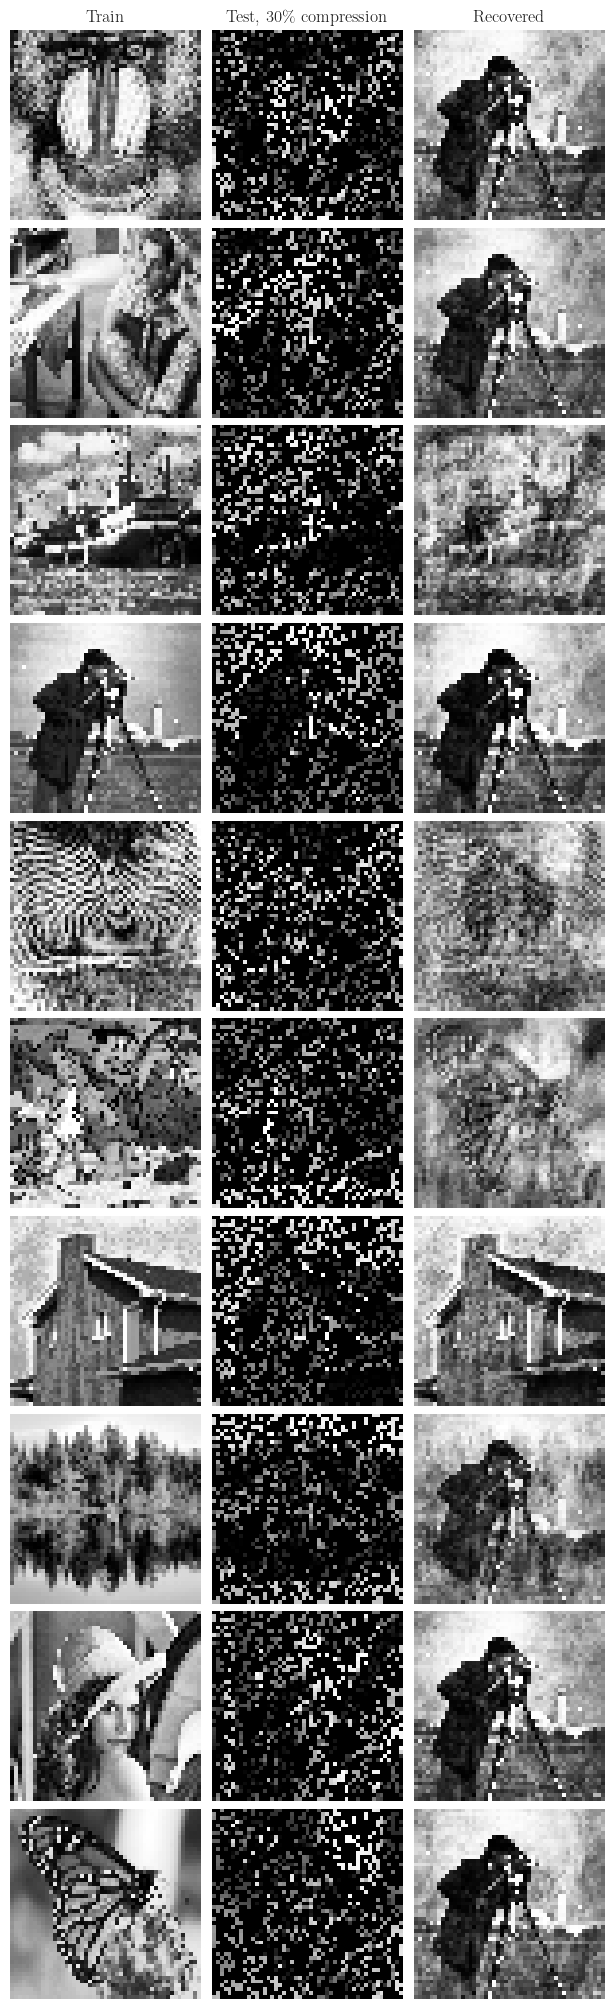

loss = 9152.12109375 
 psnr = 13.192891120910645 
 ssim = 0.4734378159046173


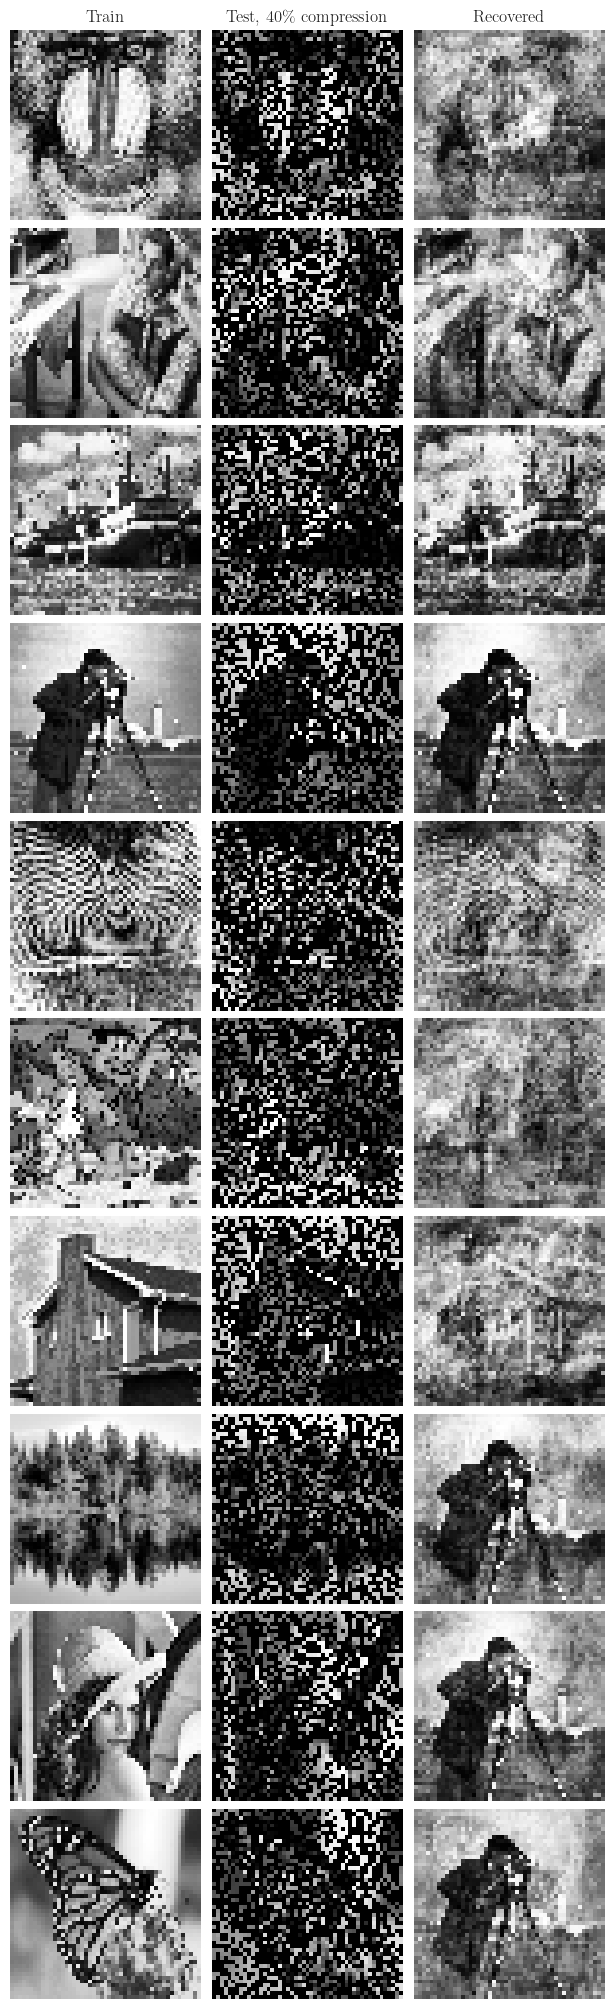

loss = 7022.5498046875 
 psnr = 14.916472434997559 
 ssim = 0.6016767024993896


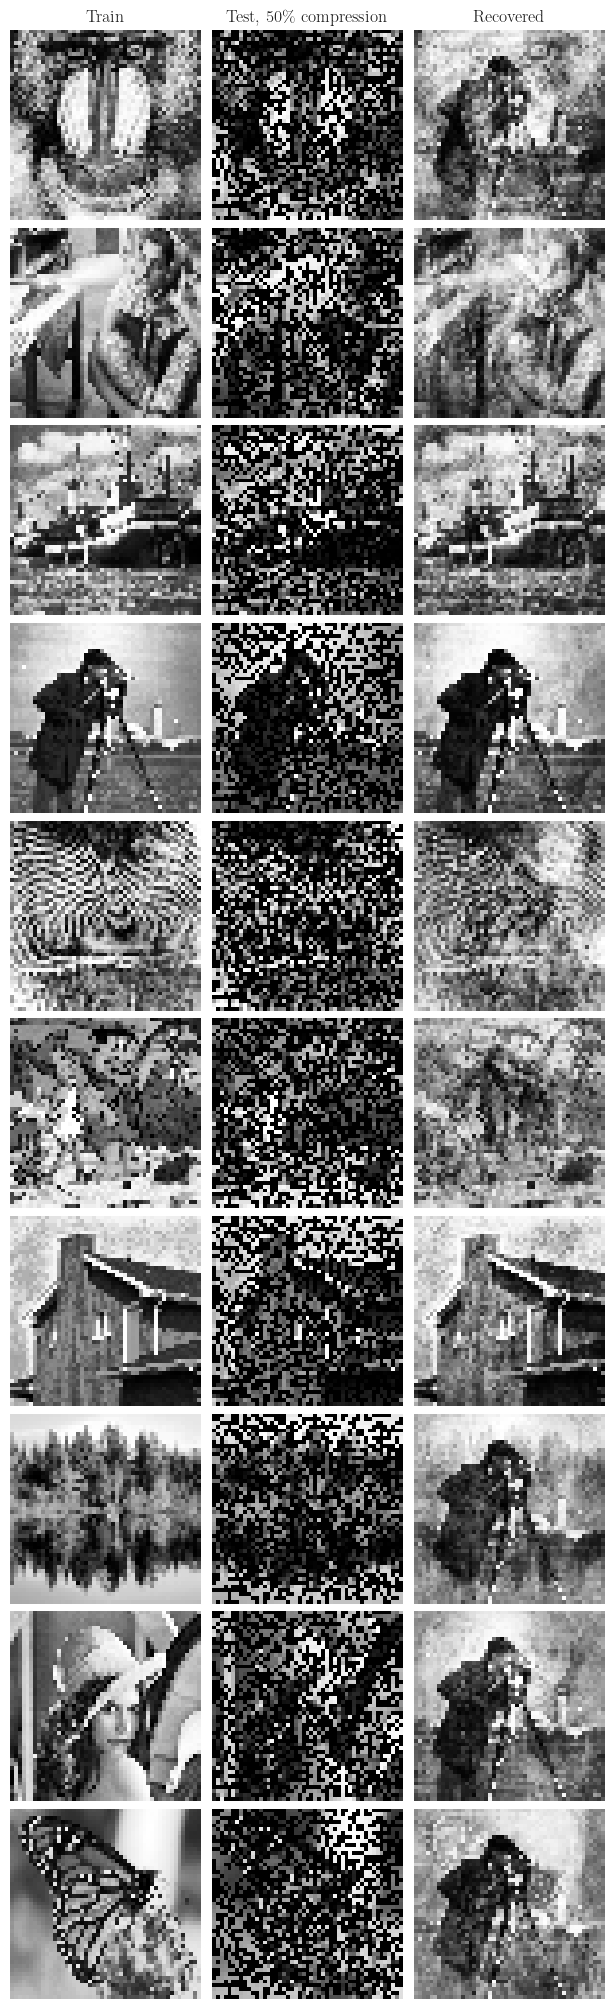

loss = 6103.29736328125 
 psnr = 15.624761581420898 
 ssim = 0.6559135317802429


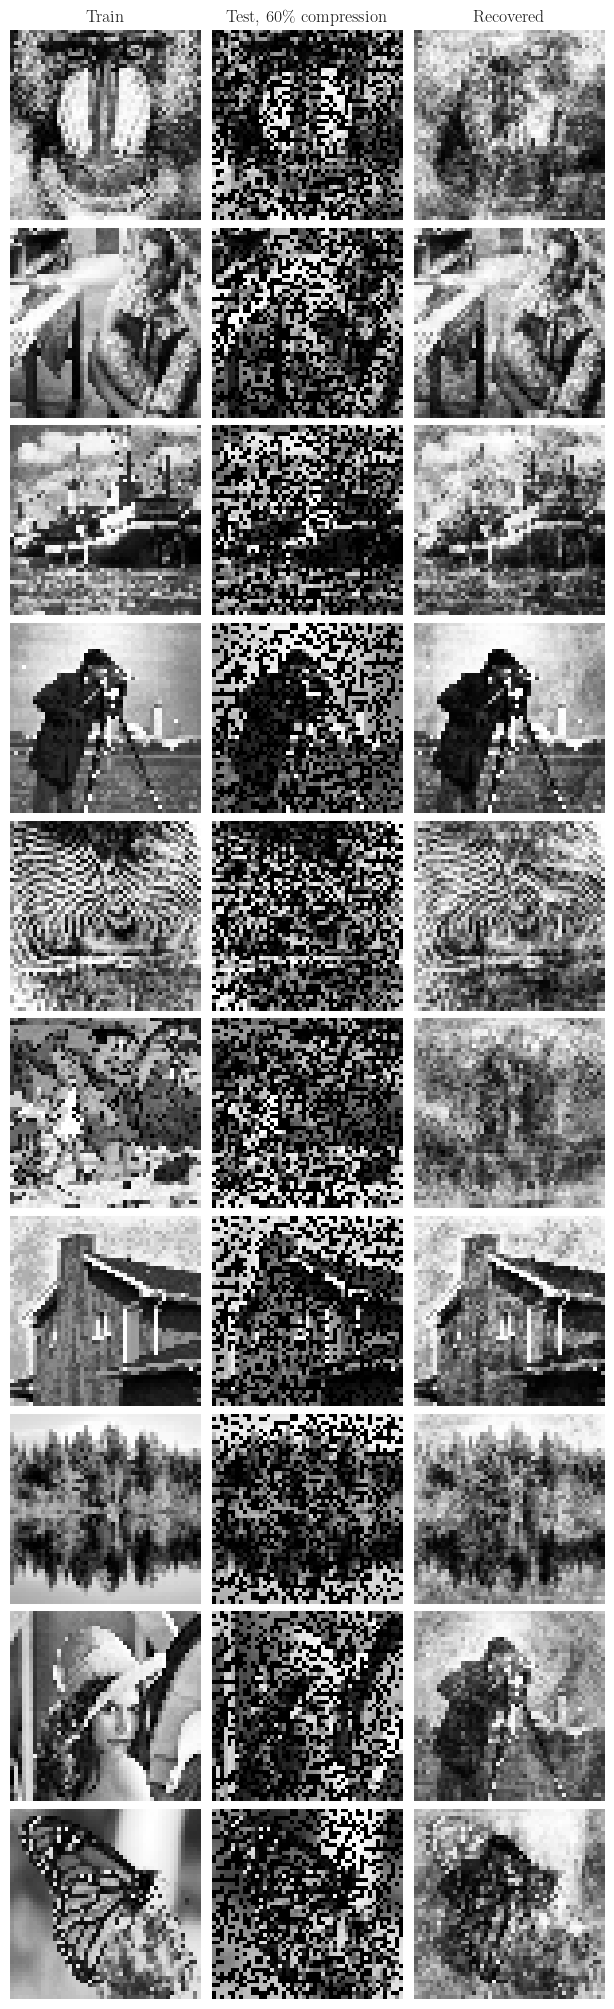

loss = 1772.71533203125 
 psnr = 19.9676513671875 
 ssim = 0.8749859929084778


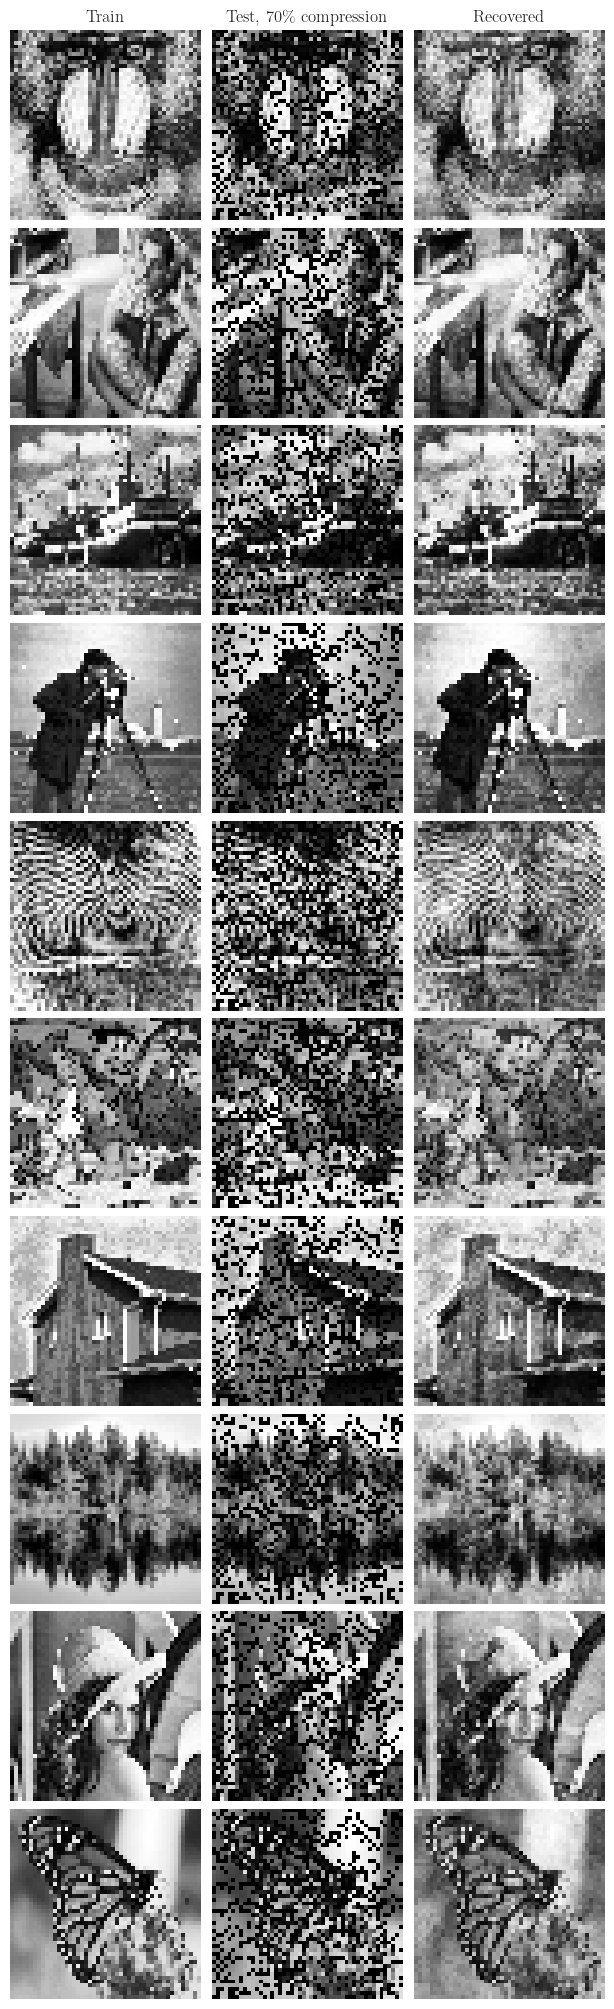

loss = 739.572509765625 
 psnr = 23.631792068481445 
 ssim = 0.939177393913269


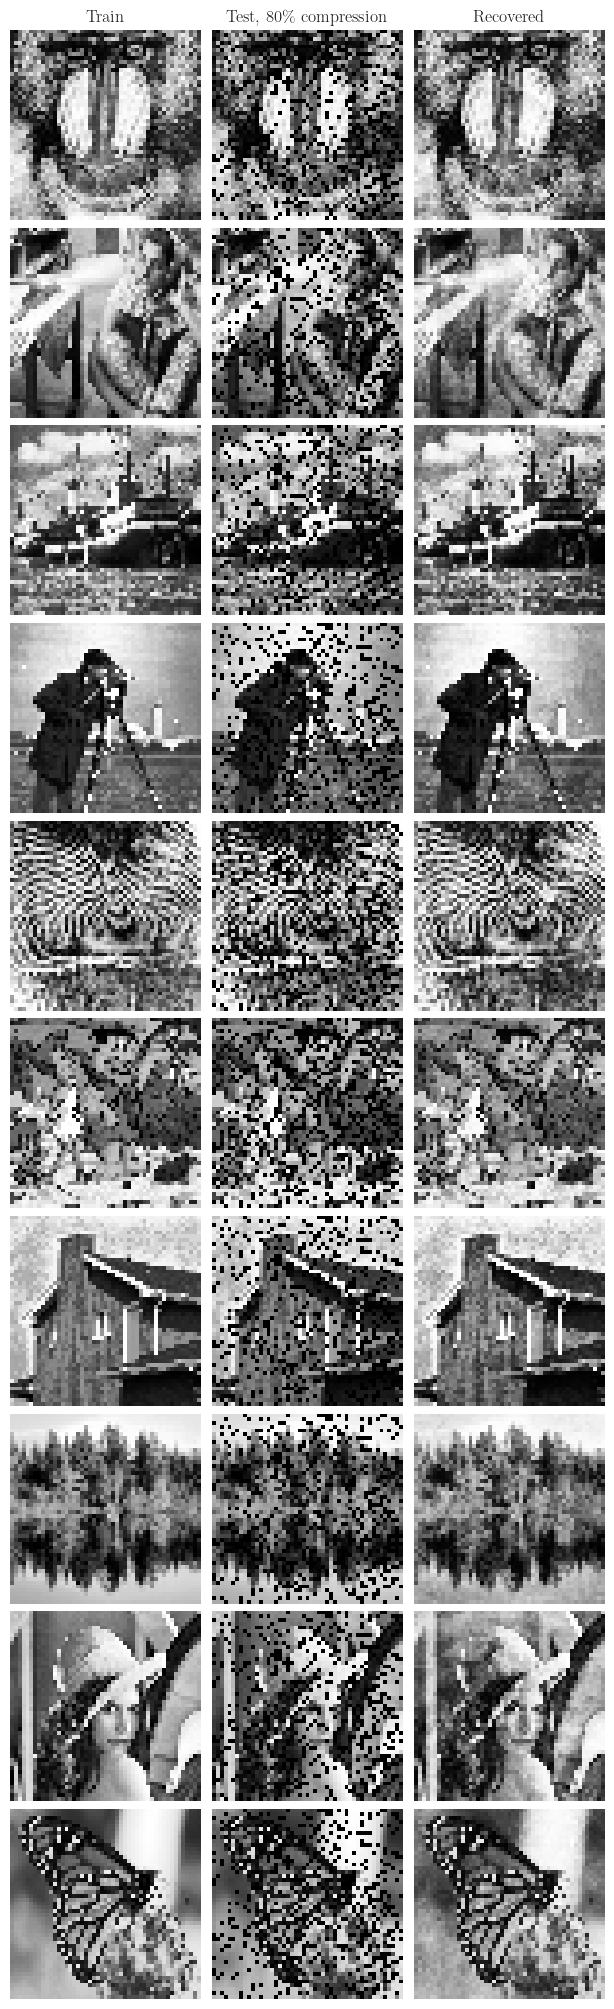

loss = 207.6688690185547 
 psnr = 28.962852478027344 
 ssim = 0.9819755554199219


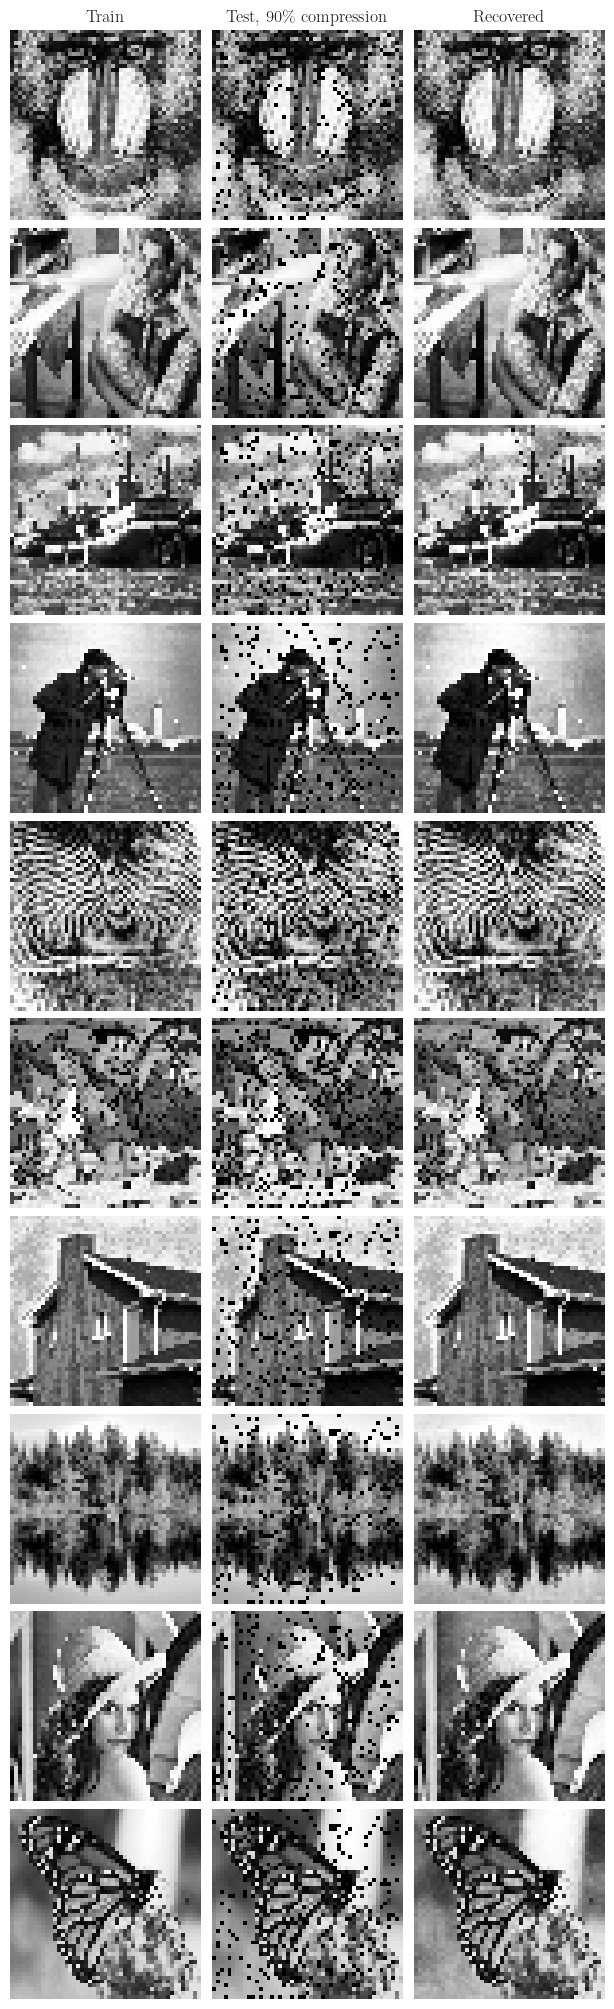

loss = 0.8846595883369446 
 psnr = 52.12081527709961 
 ssim = 0.9999276399612427


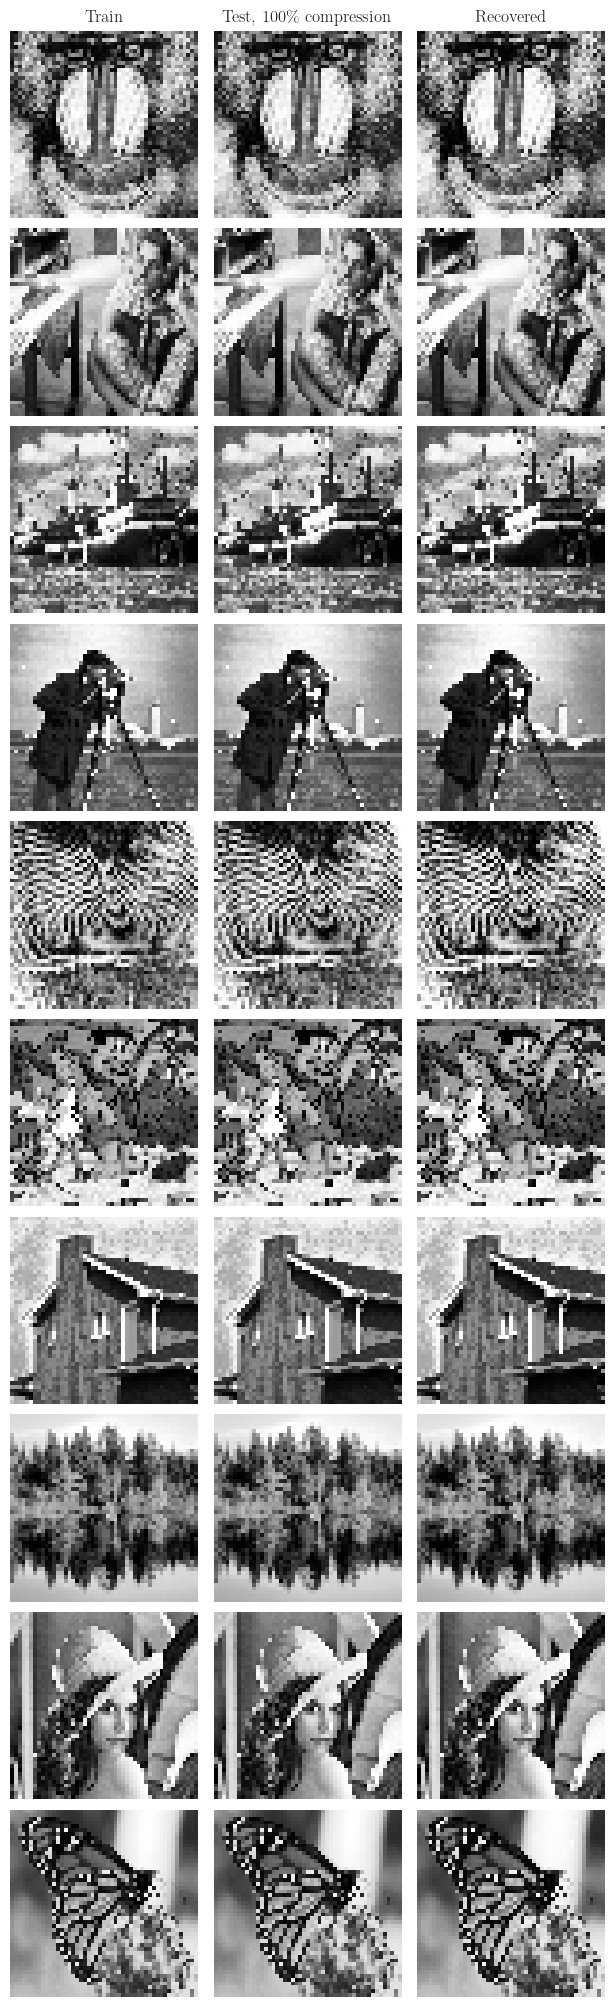

In [19]:
for p in np.concatenate(([0.01], np.arange(0.0, 1.1, 0.1))):
    mask = rand.choice([0, 1], size=(img_h, img_w, 1), p=[1-p, p])
    x_test = np.array([x_train0[i]*mask for i in range(len(x_train0))])

    rec = amrnn.predict(x_test/255)
    rec = (rec*255).astype('uint8')
    met = amrnn.test_on_batch(x_train0/255, rec/255)

    print('loss = {} \n psnr = {} \n ssim = {}'.format(*met))

    fig, ax = mp.subplots(cap, 3, figsize=(6, cap*2))
#     ax = np.expand_dims(ax, 0)
    for i in range(cap):
        if i == 0:
            ax[i, 0].set_title('Train')
            ax[i, 1].set_title('Test, {}\% compression'.format(int(p*100)))
            ax[i, 2].set_title('Recovered')
        ax[i, 0].imshow(x_train0[i,:,:,0], 'gray')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(x_test[i,:,:,0], 'gray')
        ax[i, 1].axis('off')
        ax[i, 2].imshow(rec[i,:,:,0], 'gray')
        ax[i, 2].axis('off')

#     mp.savefig(sessiondir + '%ipx_%iinputs_%ipcratio.png' \
#                              %(img_w, cap, int(p*100)),
#                dpi=300,
#                bbox_inches='tight',
#                transparent=True)
    mp.grid(False)
    mp.tight_layout(pad=0.2)
    mp.show()

In [6]:
border_percent = np.concatenate(([0.01], np.arange(0.1, 1.1, 0.1)))
borderpc = np.round(border_percent*100).astype(int)
bat_loss = np.zeros_like(border_percent)
bat_psnr = np.zeros_like(border_percent)
bat_ssim = np.zeros_like(border_percent)

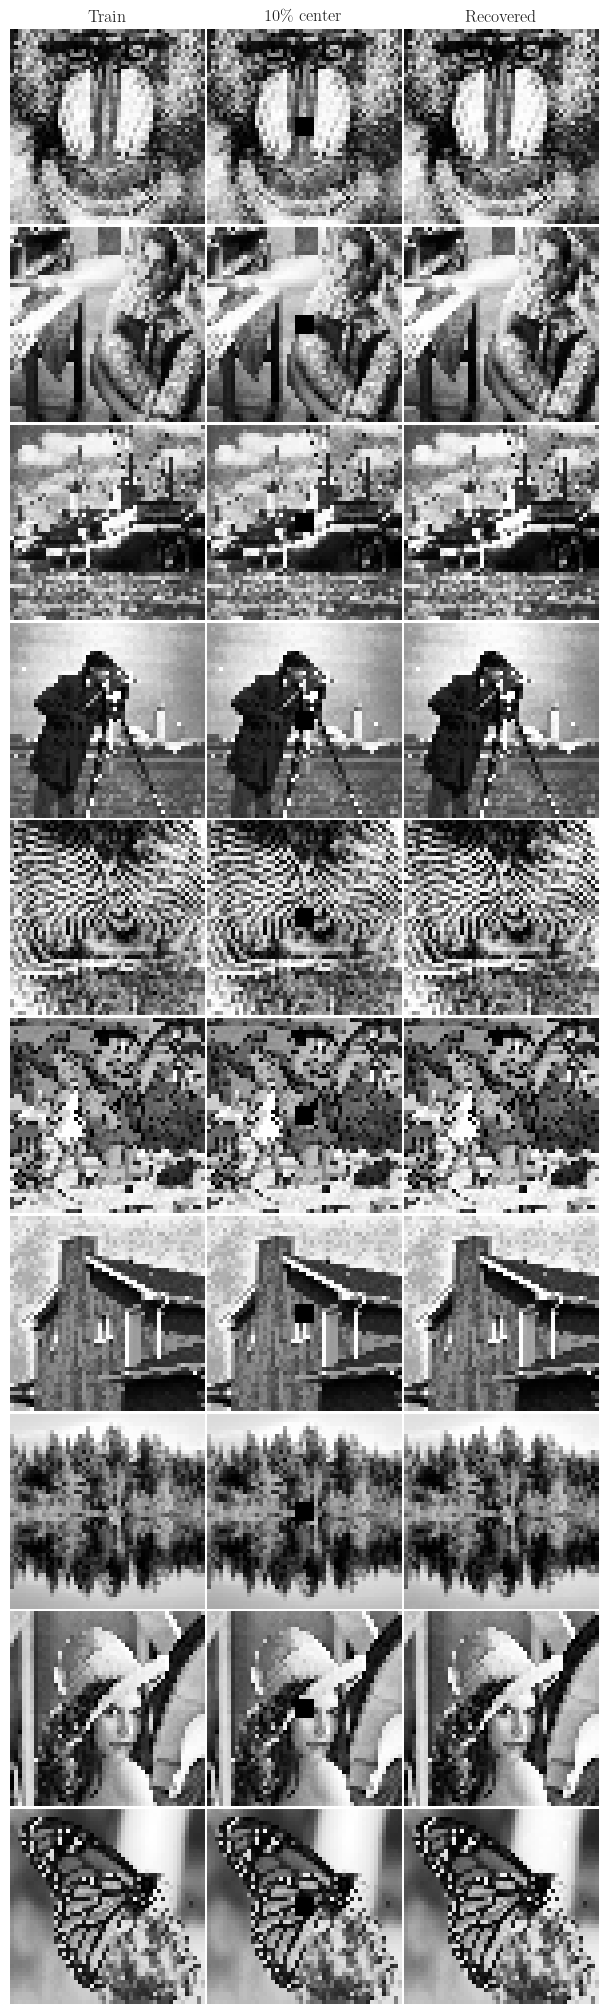

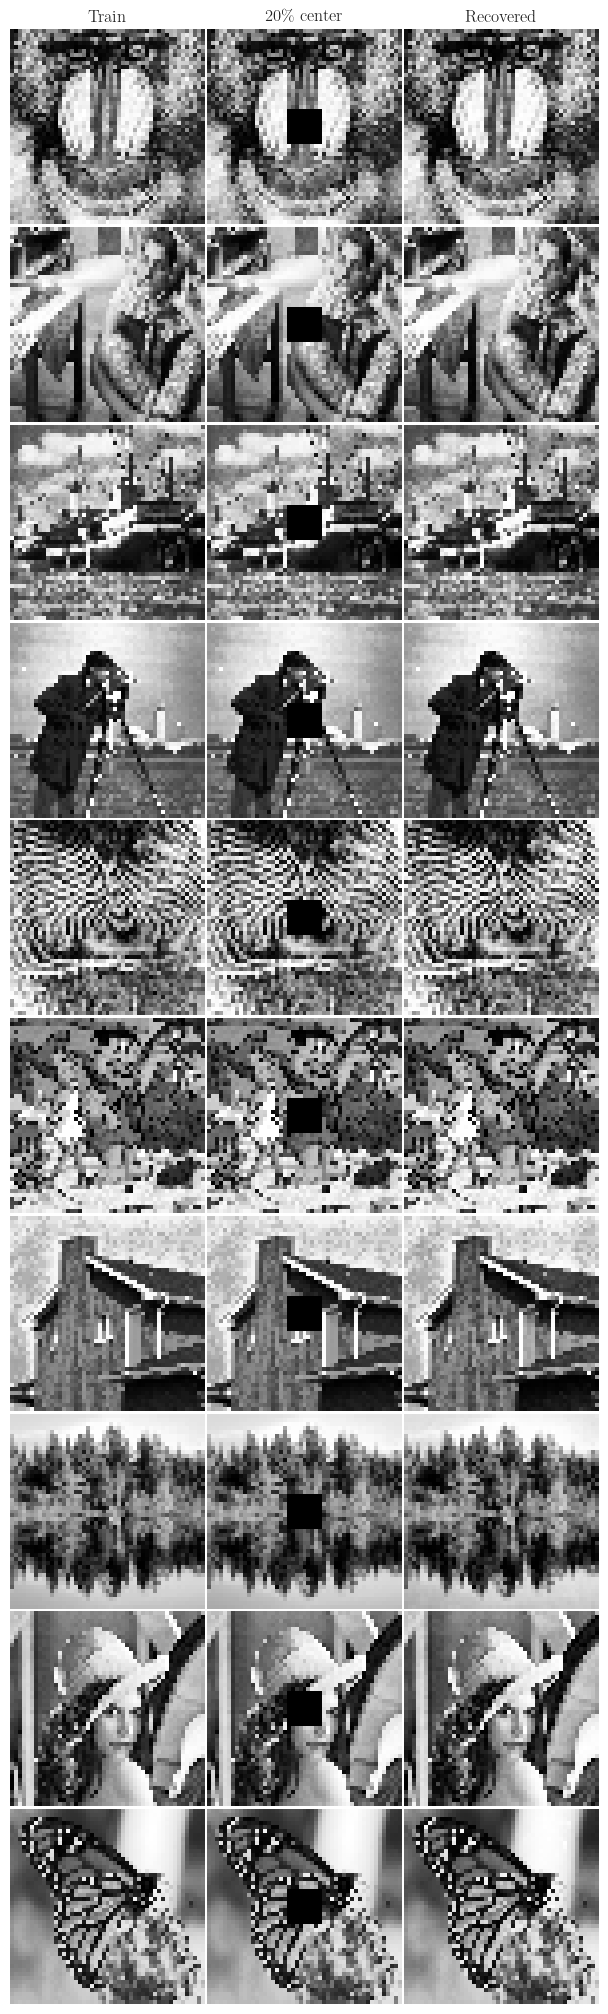

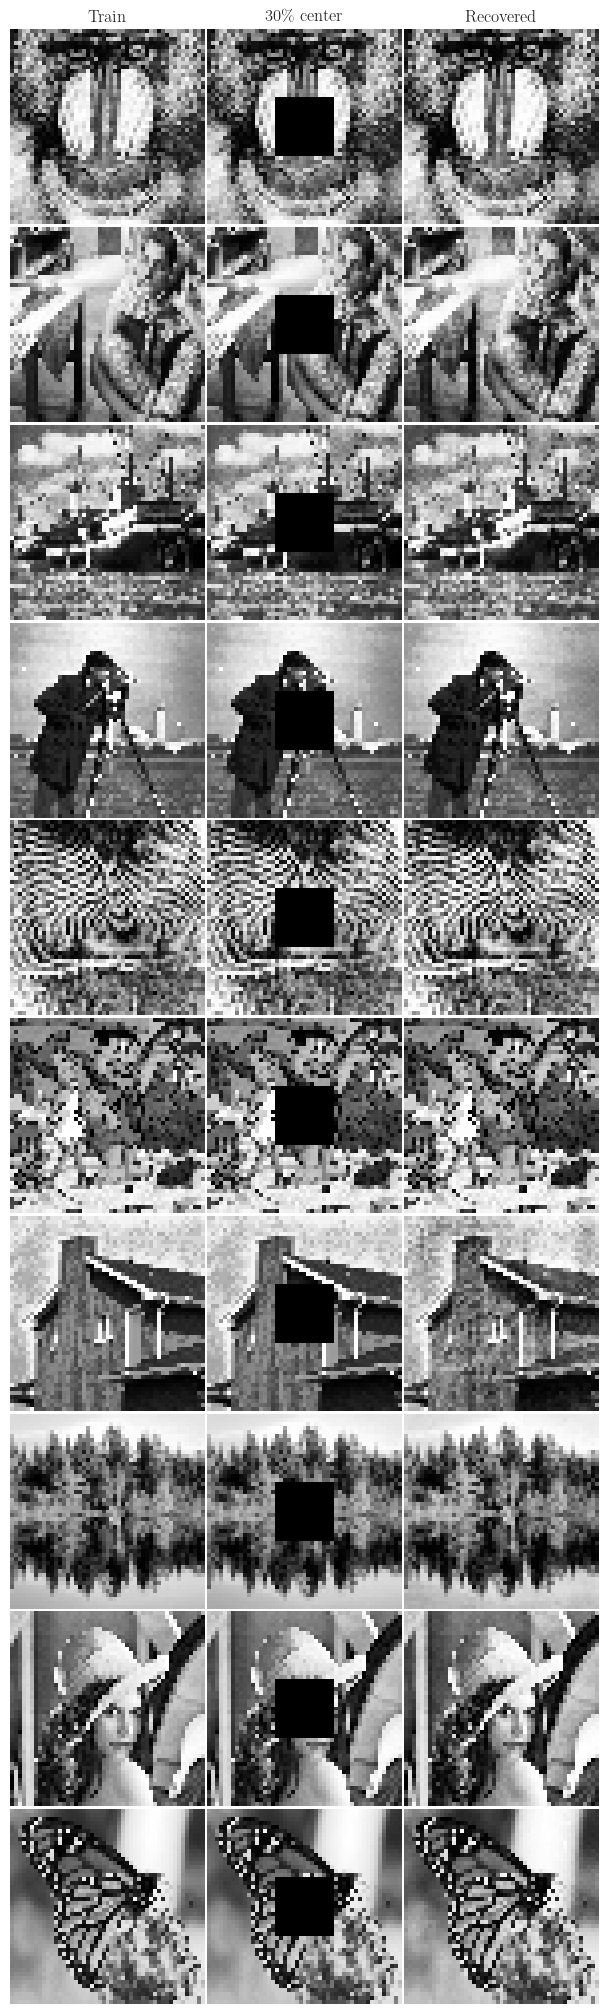

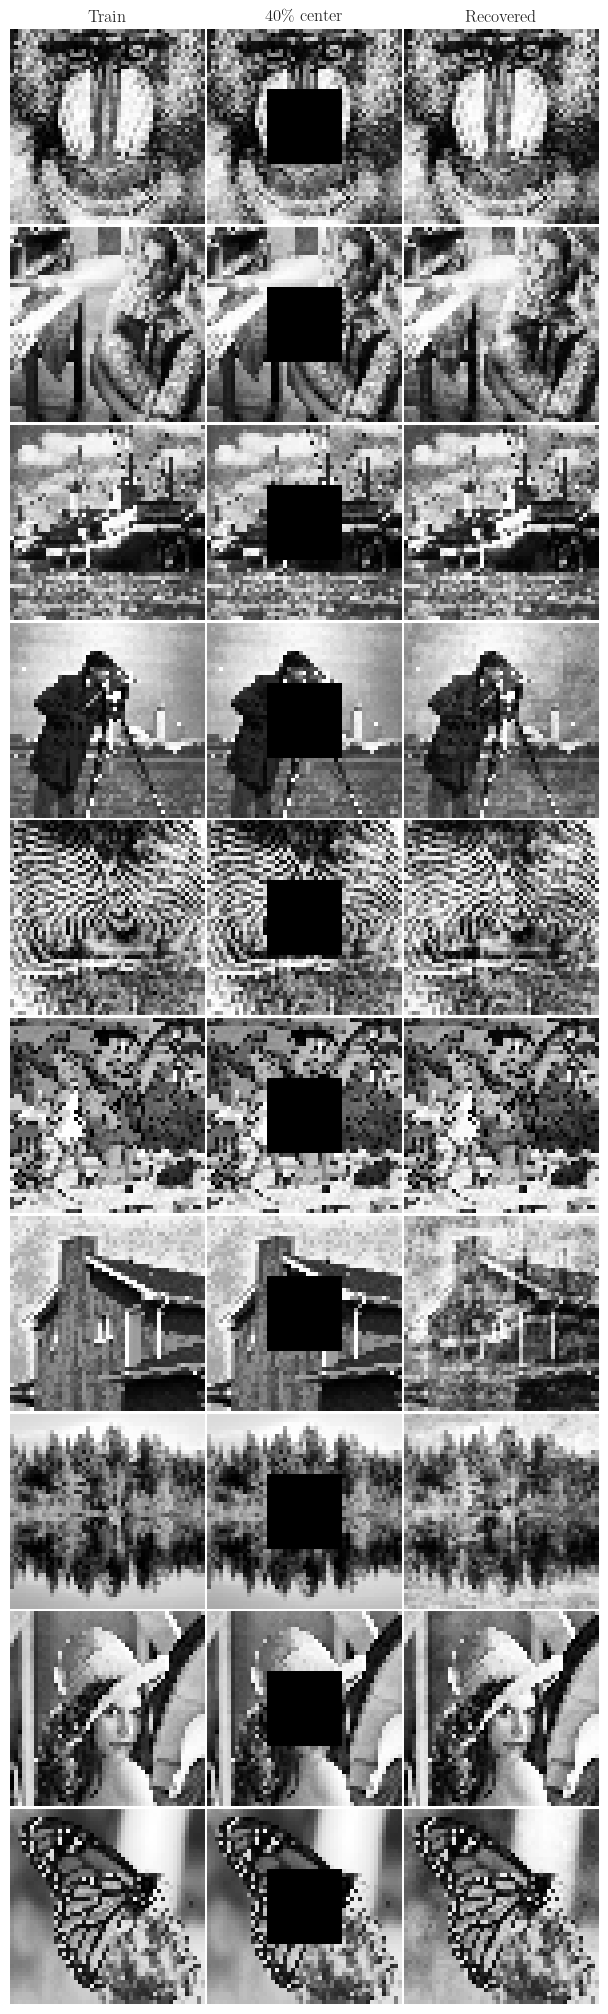

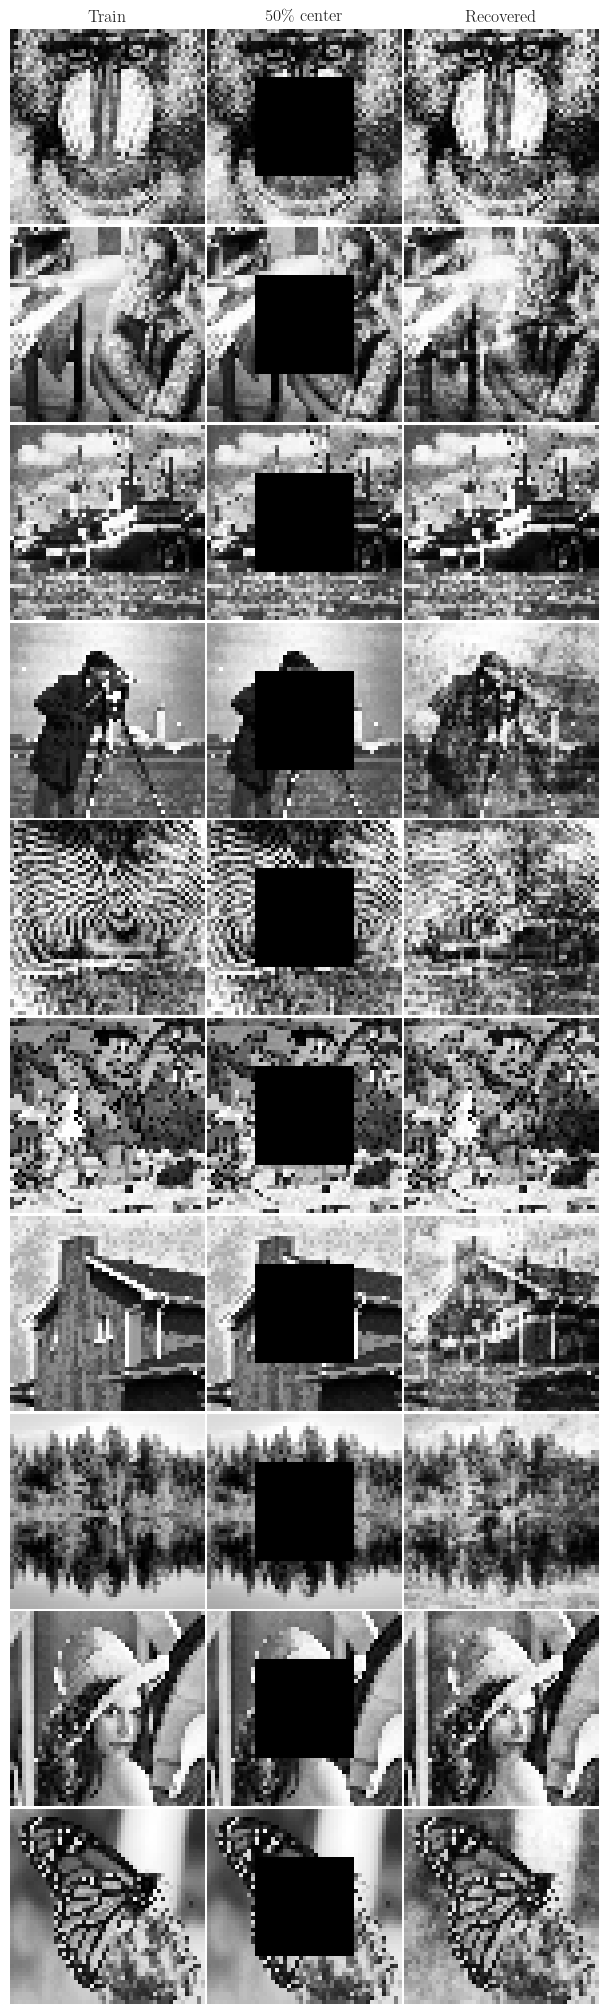

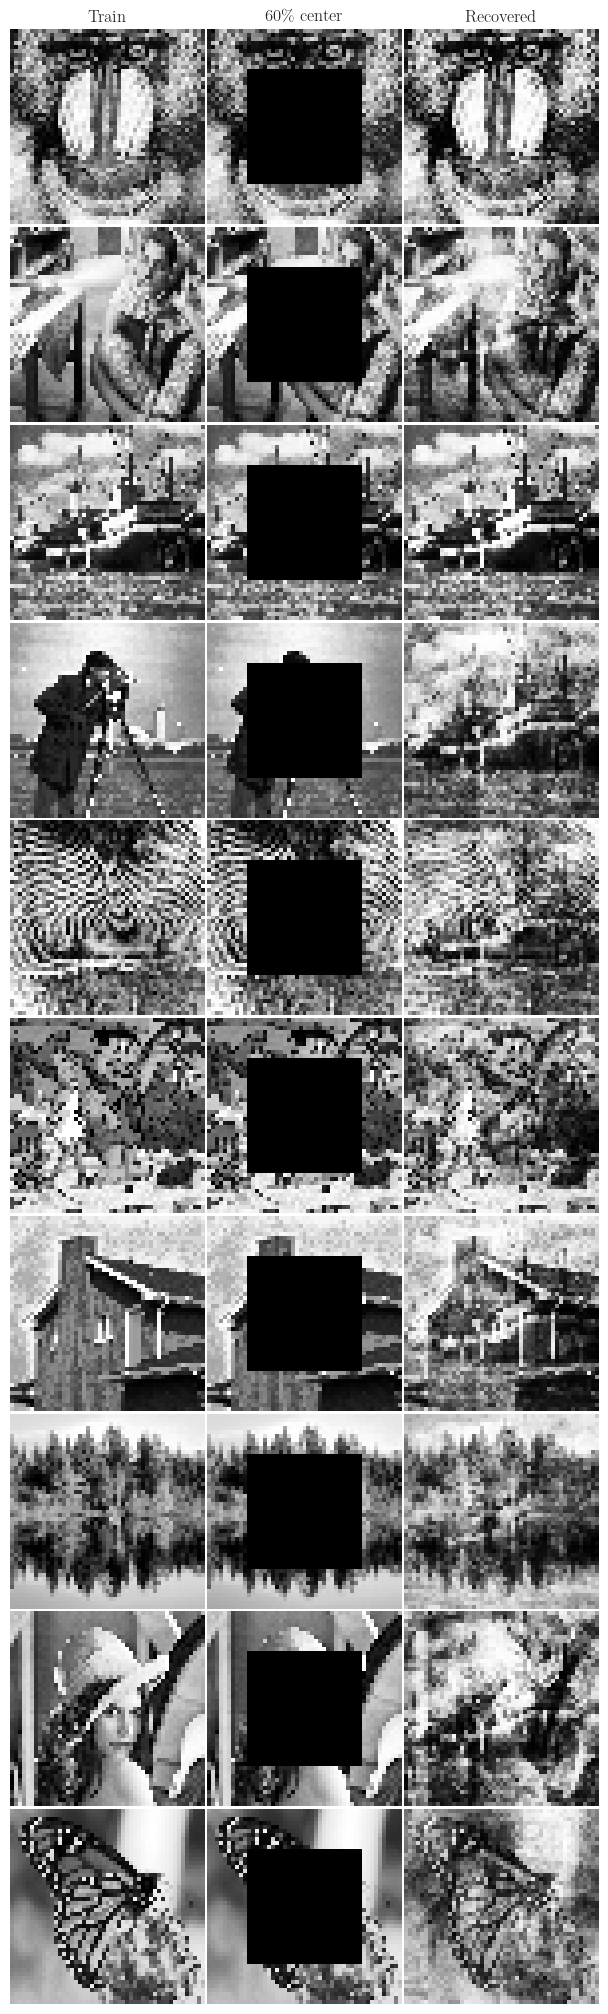

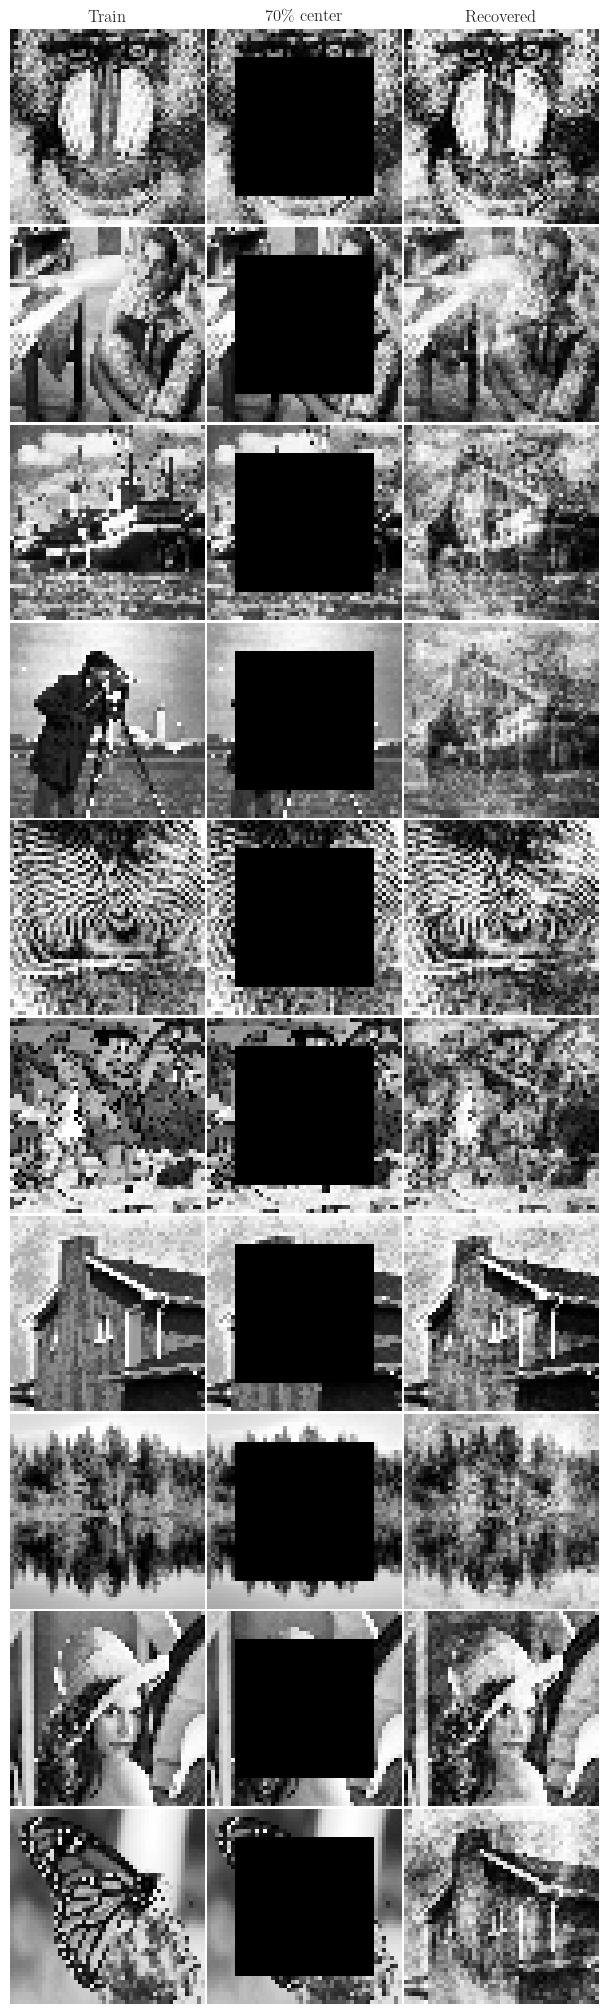

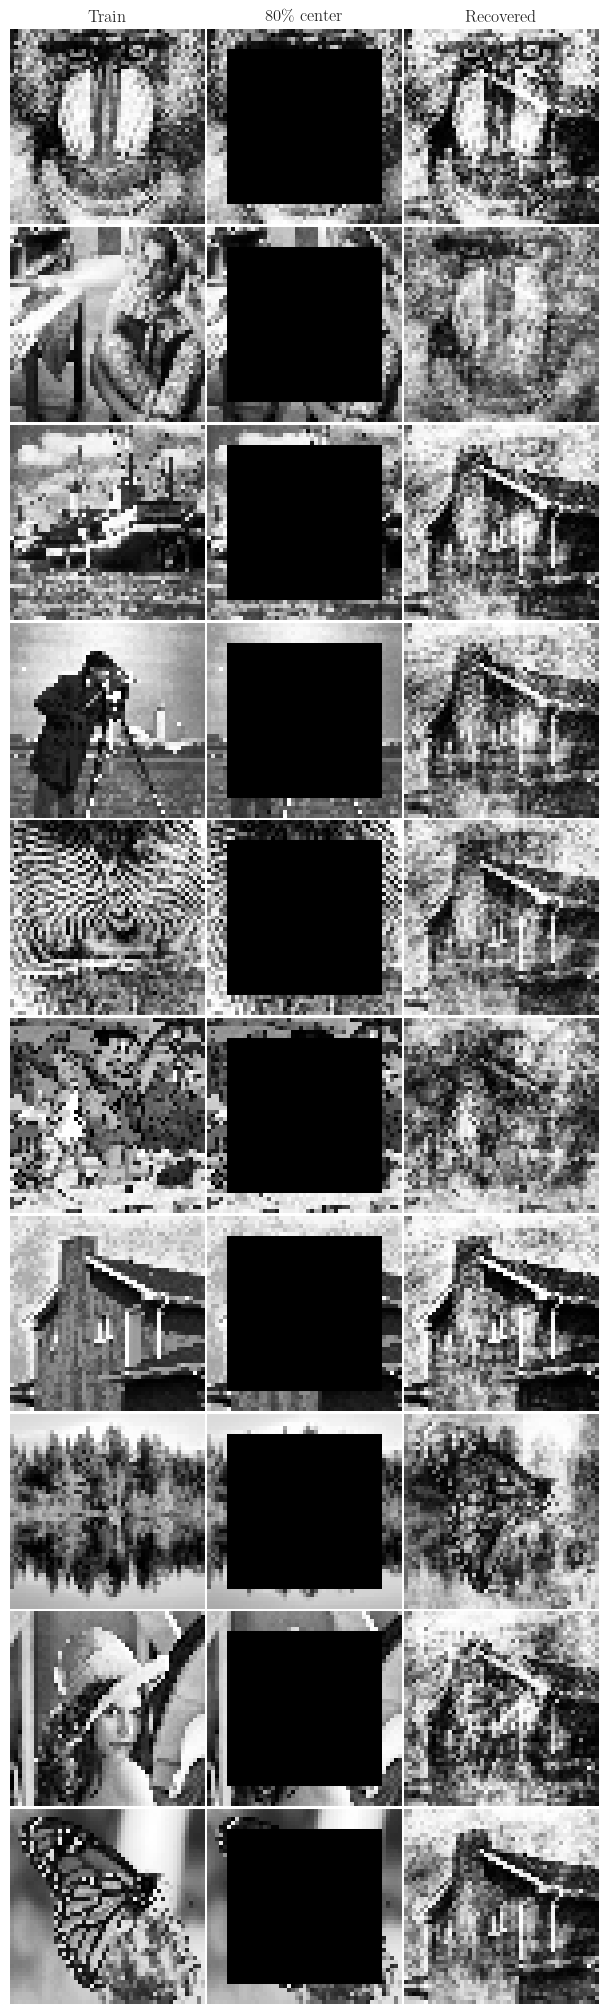

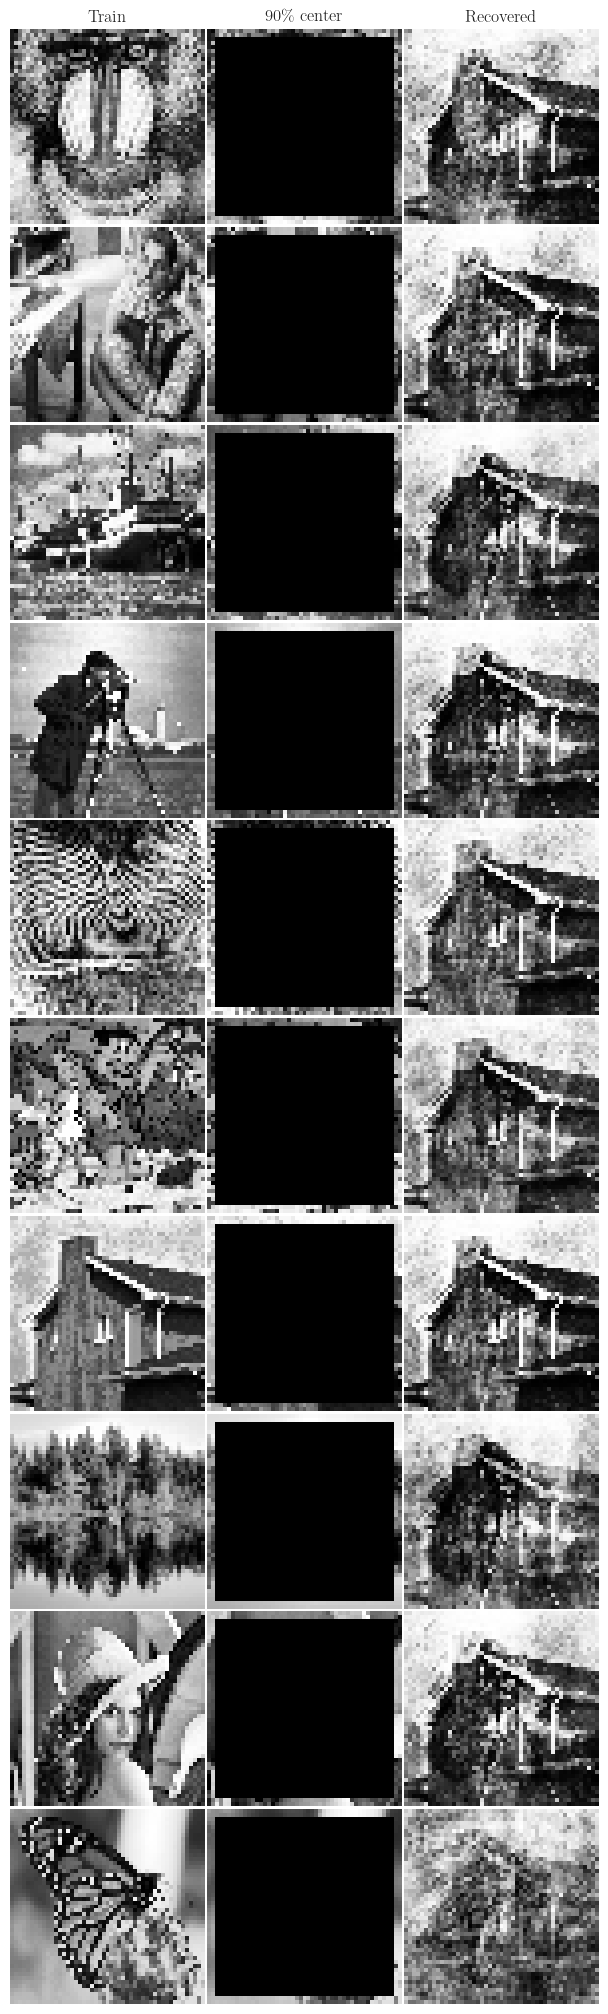

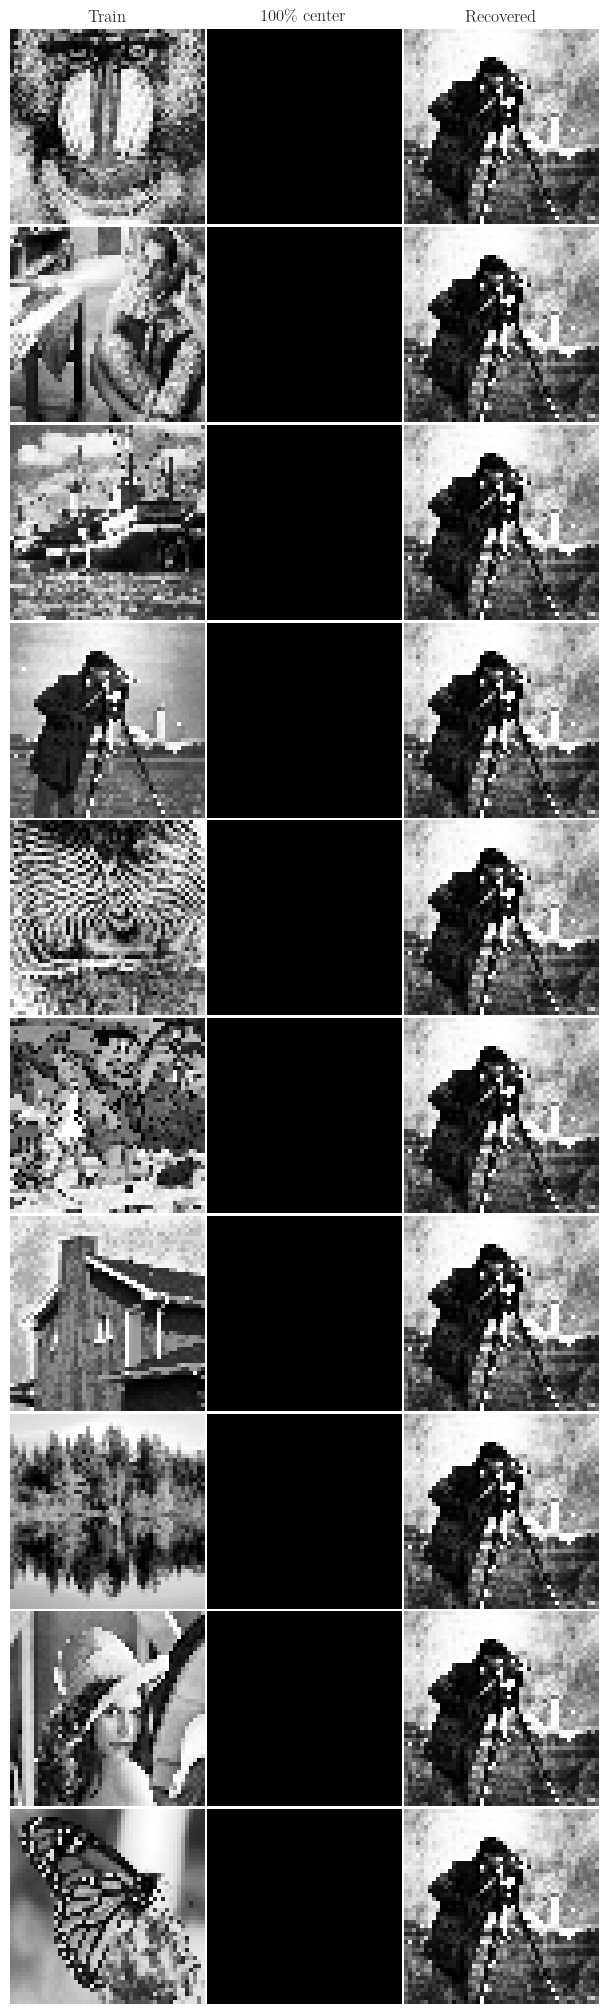

In [20]:
for j, b in enumerate(border_percent):
    border_mask = np.ones_like(x_train0[0])
    L = len(border_mask)
    border_size = int(L*b)//2
    border_mask[L//2-border_size : L//2+border_size+1, 
                L//2-border_size : L//2+border_size+1] = 0

    x_test = np.array([x_train0[i]*border_mask for i in range(len(x_train0))])

    rec = amrnn.predict(x_test/255)
    rec = (rec*255).astype('uint8')
    mets = amrnn.test_on_batch(x_train0/255, rec/255)
    bat_loss[j] = mets[0]
    bat_psnr[j] = mets[1]
    bat_ssim[j] = mets[2]

#     print('loss = {} \n psnr = {} \n ssim = {}'.format(*met))

    fig, ax = mp.subplots(cap, 3, figsize=(6, cap*2))
#     ax = np.expand_dims(ax, 0)
    for i in range(cap):
        if i == 0:
            ax[i, 0].set_title('Train')
            ax[i, 1].set_title(r'{}\% center'.format(borderpc[j]))
            ax[i, 2].set_title('Recovered')
        ax[i, 0].imshow(x_train0[i,:,:,0], 'gray')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(x_test[i,:,:,0], 'gray')
        ax[i, 1].axis('off')
        ax[i, 2].imshow(rec[i,:,:,0], 'gray')
        ax[i, 2].axis('off')

#     mp.savefig(sessiondir + '%iinputs_%ipc_centerocc.png' %(cap, borderpc[j]),
#                dpi=300,
#                bbox_inches='tight',
#                transparent=True)
    mp.grid(False)
    mp.tight_layout(pad=0.2)
    mp.show()
    
# np.save(sessiondir + '%iinputs_batch_loss.npy' %cap, bat_loss)
# np.save(sessiondir + '%iinputs_batch_psnr.npy' %cap, bat_psnr)
# np.save(sessiondir + '%iinputs_batch_ssim.npy' %cap, bat_ssim)

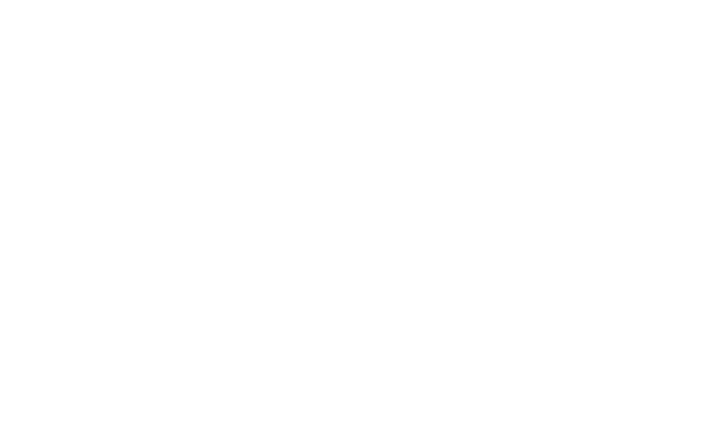

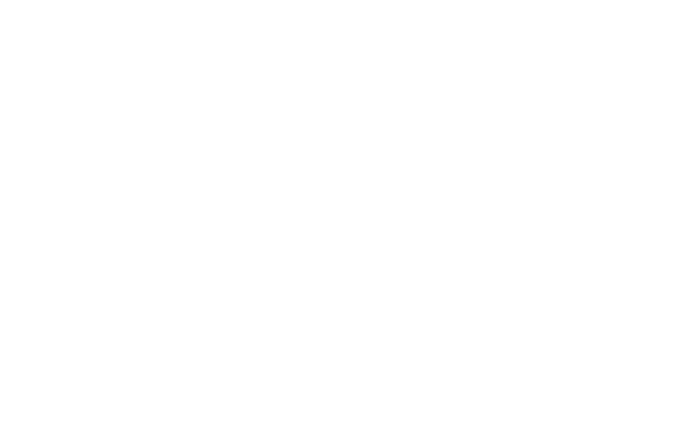

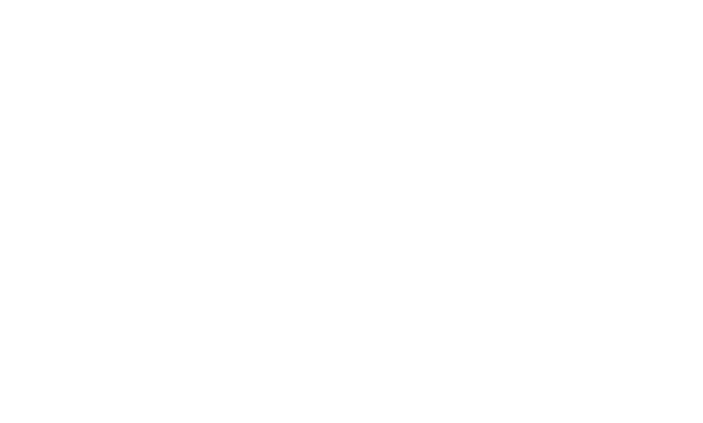

In [19]:
with plt.rc_context({'axes.edgecolor': 'w',
                    'xtick.color': 'w',
                    'ytick.color': 'w',
                    'axes.labelcolor': 'w',
                    'text.color': 'w'
                   }):
    plt.plot(borderpc, bat_loss, 'wo')
    plt.xlabel('center occlusion percent')
    plt.ylabel('$\ell_2$ loss')
    plt.savefig(sessiondir + 'PR-%iinputs_batch_loss.png' %cap,
               dpi=300, bbox_inches='tight',
               transparent=True)
    plt.show()

    plt.plot(borderpc, bat_psnr, 'wo')
    plt.xlabel('center occlusion percent')
    plt.ylabel('PSNR')
    plt.savefig(sessiondir + 'PR-%iinputs_batch_psnr.png' %cap,
               dpi=300, bbox_inches='tight',
              transparent=True)
    plt.show()

    plt.plot(borderpc, bat_ssim, 'wo')
    plt.xlabel('center occlusion percent')
    plt.ylabel('SSIM')
    plt.savefig(sessiondir + 'PR-%iinputs_batch_ssim.png' %cap,
               dpi=300, bbox_inches='tight',
              transparent=True)
    plt.show()

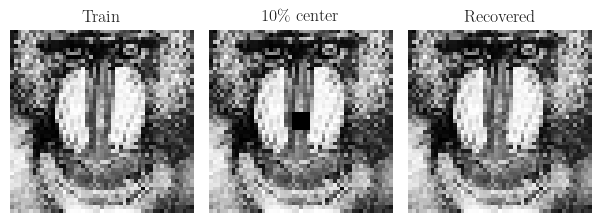

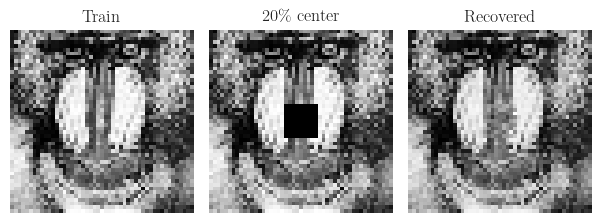

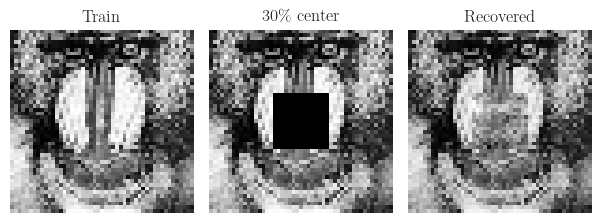

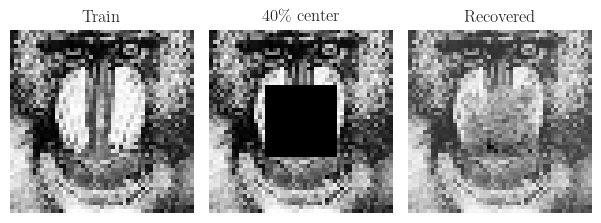

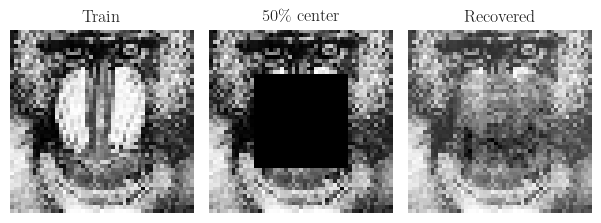

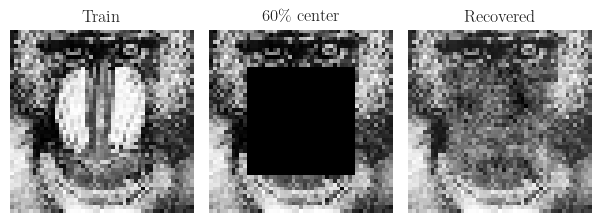

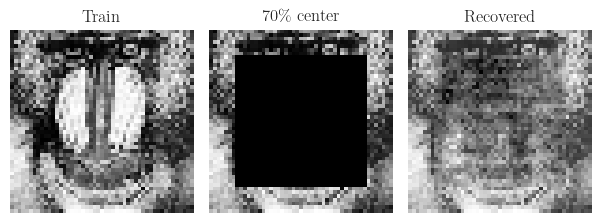

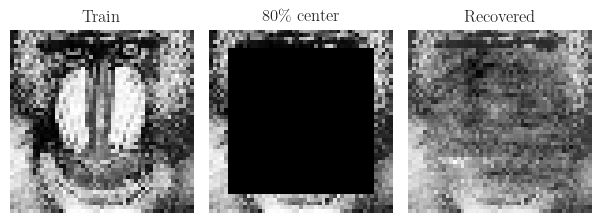

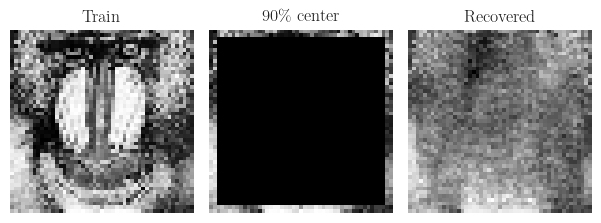

D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


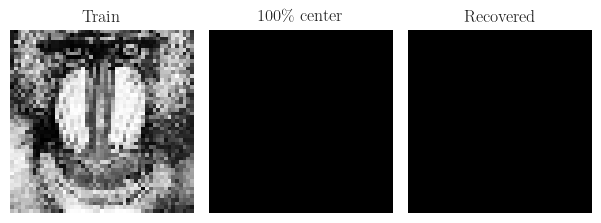

In [134]:
owl_loss = np.zeros_like(border_percent)
owl_psnr = np.zeros_like(border_percent)
owl_ssim = np.zeros_like(border_percent)

for j, b in enumerate(border_percent):
    border_mask = np.ones_like(x_train0[0], dtype='uint8')
    border_mask = np.squeeze(border_mask)
    L = len(border_mask)
    border_size = int(L*b)//2
    border_mask[L//2-border_size : L//2+border_size+1, 
                L//2-border_size : L//2+border_size+1] = 0
    ri = np.ravel(np.where(border_mask.ravel() != 0))
    x_test = np.squeeze(x_train0[0].astype('uint8')) * border_mask
    ny, nx = x_test.shape
    b = x_test.flat[ri].astype(float)
    rec = fmin_lbfgs(evaluate, x_test, None, orthantwise_c=3.2, m=5)
    rec.reshape(ny, nx)
    rec = idct2(rec)

    owl_psnr[j] = skm.compare_psnr(x_test/x_test.max(), rec/rec.max())
    owl_ssim[j] = skm.compare_ssim(x_test/x_test.max(), rec/rec.max())
    with tf.Session() as sess:
        x_test = np.expand_dims(x_test, 0)
        rec = np.expand_dims(rec, 0)
        Txtest = tf.convert_to_tensor(x_test/x_test.max())
        Trec = tf.convert_to_tensor(rec/rec.max())
        owl_loss[j] = sess.run(tf.nn.l2_loss(Trec - Txtest))
    
    fig, ax = mp.subplots(1, 3, figsize=(6, 2))
    ax = np.expand_dims(ax, 0)
    for i in range(1):
        if i == 0:
            ax[i, 0].set_title('Train')
            ax[i, 1].set_title(r'{}\% center'.format(borderpc[j]))
            ax[i, 2].set_title('Recovered')
        ax[i, 0].imshow(x_train0[i,:,:,0], 'gray')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(x_test[i,:,:], 'gray')
        ax[i, 1].axis('off')
        ax[i, 2].imshow(rec[i,:,:], 'gray')
        ax[i, 2].axis('off')

#     mp.savefig(sessiondir + '%iinputs_%ipc_centerocc_OWLQN.png' %(cap, borderpc[j]),
#                dpi=300,
#                bbox_inches='tight',
#                transparent=True)
    mp.grid(False)
    mp.tight_layout(pad=0.2)
    mp.show()
    
np.save(sessiondir + '%iinputs_owl_loss.npy' %cap, owl_loss)
np.save(sessiondir + '%iinputs_owl_psnr.npy' %cap, owl_psnr)
np.save(sessiondir + '%iinputs_owl_ssim.npy' %cap, owl_ssim)

In [9]:
bat_loss = np.load('D:/Kenneth/Documents/VIP/Experiments/AMNN-5/20190930/10inputs_batch_loss.npy')
bat_psnr = np.load('D:/Kenneth/Documents/VIP/Experiments/AMNN-5/20190930/10inputs_batch_psnr.npy')
bat_ssim = np.load('D:/Kenneth/Documents/VIP/Experiments/AMNN-5/20190930/10inputs_batch_ssim.npy')
owl_loss = np.load('D:/Kenneth/Documents/VIP/Experiments/AMNN-5/20191001/10inputs_owl_loss.npy')
owl_psnr = np.load('D:/Kenneth/Documents/VIP/Experiments/AMNN-5/20191001/10inputs_owl_psnr.npy')
owl_ssim = np.load('D:/Kenneth/Documents/VIP/Experiments/AMNN-5/20191001/10inputs_owl_ssim.npy')

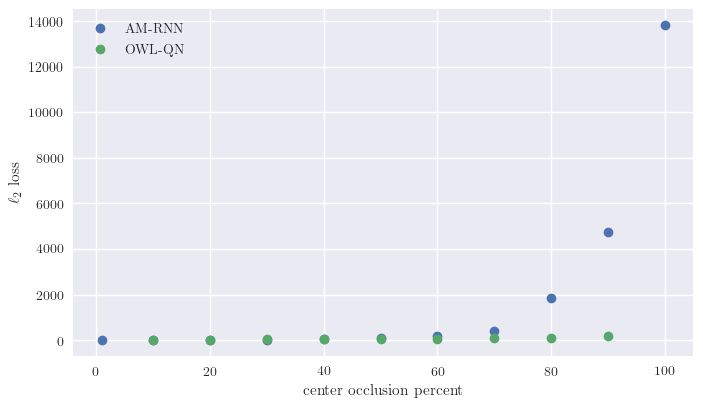

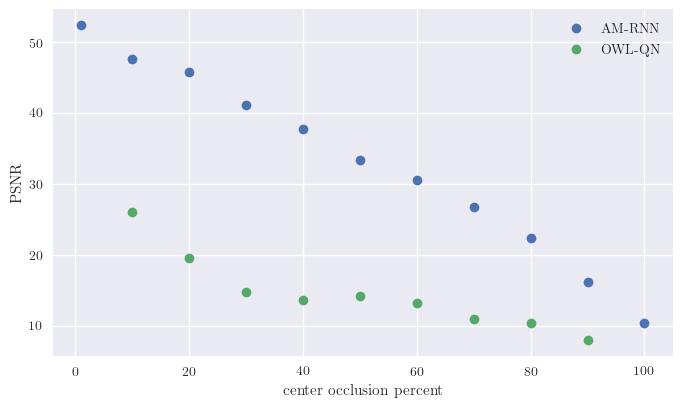

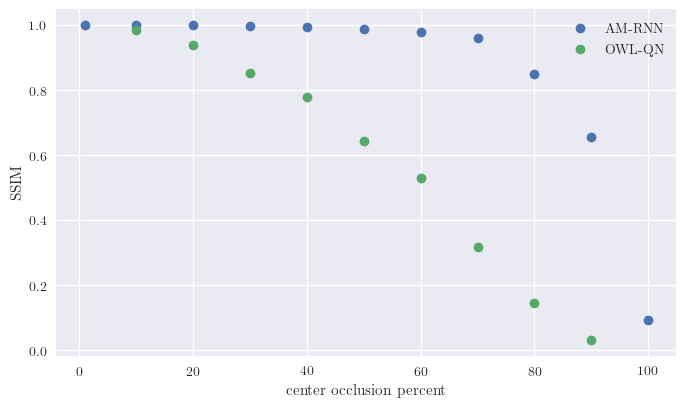

In [18]:
plt.plot(borderpc, bat_loss, 'o')
plt.plot(borderpc[1:], owl_loss, 'o')
plt.xlabel('center occlusion percent')
plt.ylabel('$\ell_2$ loss')
plt.legend(['AM-RNN', 'OWL-QN'])
# plt.savefig(sessiondir + '%iinputs_batch_loss.png' %cap,
#            dpi=300, bbox_inches='tight')
plt.show()

plt.plot(borderpc, bat_psnr, 'o')
plt.plot(borderpc[1:], owl_psnr, 'o')
plt.xlabel('center occlusion percent')
plt.ylabel('PSNR')
plt.legend(['AM-RNN', 'OWL-QN'])
# plt.savefig(sessiondir + '%iinputs_batch_psnr.png' %cap,
#            dpi=300, bbox_inches='tight')
plt.show()

plt.plot(borderpc, bat_ssim, 'o')
plt.plot(borderpc[1:], owl_ssim, 'o')
plt.xlabel('center occlusion percent')
plt.ylabel('SSIM')
plt.legend(['AM-RNN', 'OWL-QN'])
# plt.savefig(sessiondir + '%iinputs_batch_ssim.png' %cap,
#            dpi=300, bbox_inches='tight')
plt.show()

In [21]:
bat_psnr[7]

26.804067611694336

In [13]:
gru_weights, gru_recurrent_weights, gru_bias = amrnn.layers[1].get_weights()
fc_weights, fc_bias = amrnn.layers[2].get_weights()
cm = 'jet'

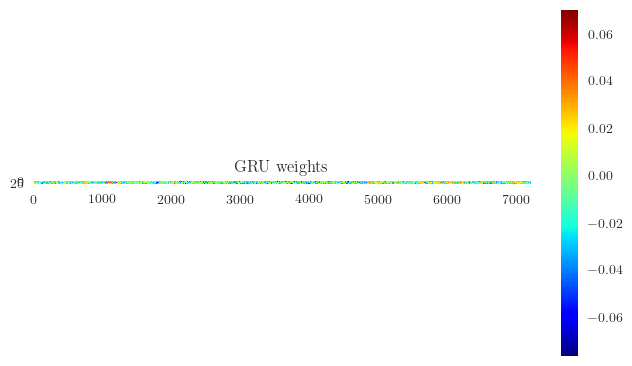

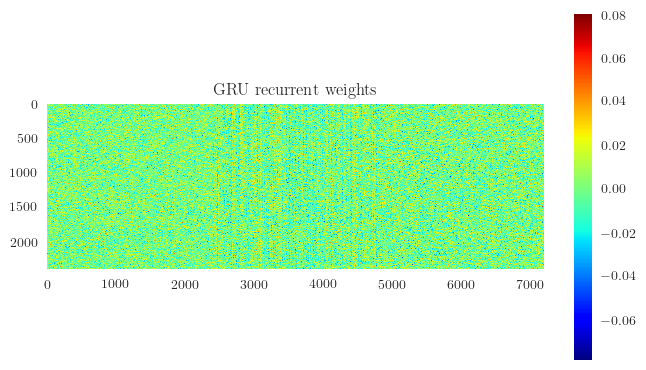

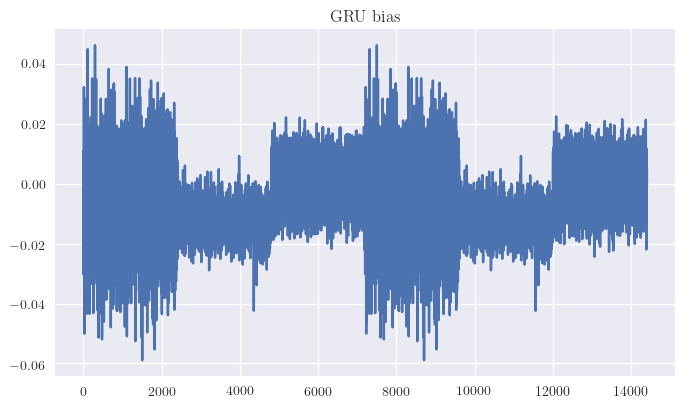

In [14]:
mp.imshow(gru_weights, cm)
mp.grid(0)
mp.colorbar()
mp.title('GRU weights')
mp.show()

mp.imshow(gru_recurrent_weights, cm)
mp.grid(0)
mp.colorbar()
mp.title('GRU recurrent weights')
mp.show()

mp.plot(gru_bias)
mp.title('GRU bias')
mp.show()

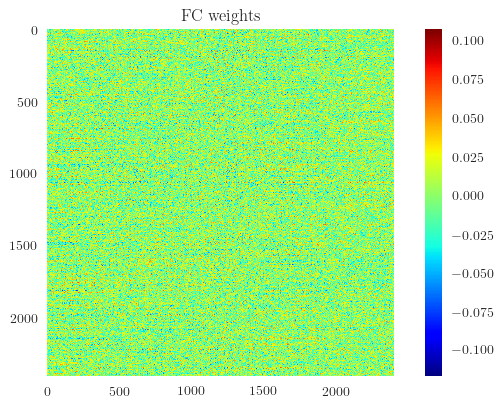

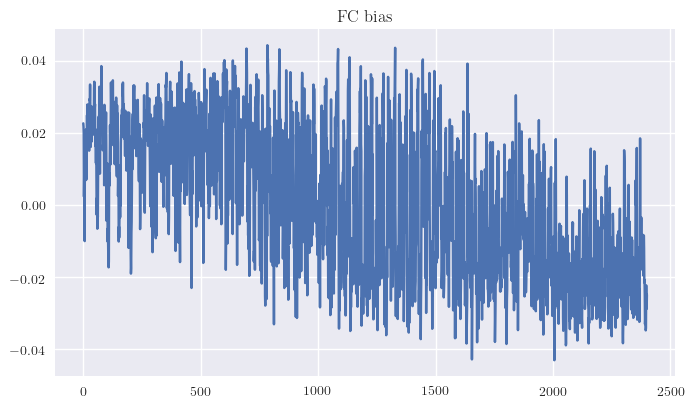

In [15]:
mp.imshow(fc_weights, cm)
mp.grid(0)
mp.colorbar()
mp.title('FC weights')
mp.show()

mp.plot(fc_bias)
mp.title('FC bias')
mp.show()

In [20]:
dct_mat = fft.dct(np.identity(2000))

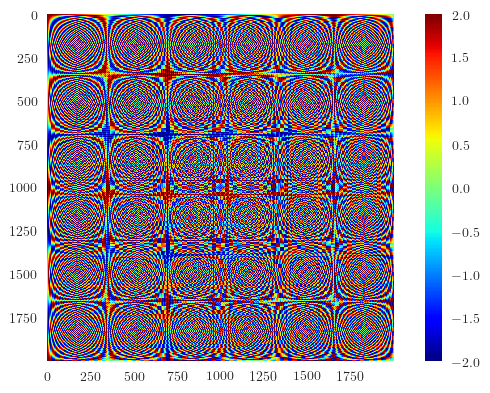

In [24]:
plt.imshow(dct_mat, cm)
plt.grid(0)
plt.colorbar()
plt.show()